# Global Explainer - ETN

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from local_explanations import *
import utils
import models

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os
import numpy as np
import wandb
import networkx as nx
from networkx.algorithms import isomorphism
from networkx.generators import classic

import torch
from torch_geometric.nn import GAE, VGAE, GCNConv
import torch_geometric.transforms as T
from torch_geometric.data import InMemoryDataset, download_url, Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.loader import DataLoader
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score

import copy
import random
from scipy.stats import hmean

from collections import defaultdict
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool, global_max_pool, GATConv, GINConv
from torch_scatter import scatter
import torch_explain as te
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity, test_explanations
from torch_geometric.datasets import MNISTSuperpixels


%load_ext autoreload
%autoreload 2

In [15]:
adjs_train , \
edge_weights_train , \
ori_adjs_train , \
ori_classes_train , \
belonging_train , \
summary_predictions_train , \
le_classes_train ,\
embeddings_train = read_etn(split="TRAIN", priori_annotation=True)

print(np.unique(le_classes_train, return_counts=True))
print(len(adjs_train) , len(edge_weights_train), len(ori_adjs_train) , len(ori_classes_train) , len(belonging_train))
np.unique(summary_predictions_train["wrong"], return_counts=True) , np.unique(summary_predictions_train["correct"], return_counts=True)

[]
defaultdict(<class 'int'>, {'{1, 2, 3}': 123, '{0, 2, 3}': 120, '{0, 2}': 6, '{2, 3}': 48, '{2}': 2, '{0, 1, 2}': 17})
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 46,  16, 433,   5, 113,  29, 234,  58, 316], dtype=int64))
1250 1250 1250 1250 1250


((array([0, 1]), array([44, 56], dtype=int64)),
 (array([0, 1]), array([660, 648], dtype=int64)))

In [16]:
adjs_val , \
edge_weights_val , \
ori_adjs_val , \
ori_classes_val , \
belonging_val , \
summary_predictions_val , \
le_classes_val ,\
embeddings_val = read_etn(split="VAL", priori_annotation=True)

print(np.unique(le_classes_val, return_counts=True))
print(len(adjs_val) , len(edge_weights_val), len(ori_adjs_val) , len(ori_classes_val) , len(belonging_val))
np.unique(summary_predictions_val["wrong"], return_counts=True) , np.unique(summary_predictions_val["correct"], return_counts=True)

[]
defaultdict(<class 'int'>, {'{0, 2, 3}': 10, '{2, 3}': 6, '{1, 2, 3}': 9, '{0, 2}': 2, '{0, 1, 2}': 1})
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 4,  1, 37,  1, 15,  4, 23,  8, 28], dtype=int64))
121 121 121 121 121


((array([0, 1]), array([5, 9], dtype=int64)),
 (array([0, 1]), array([65, 61], dtype=int64)))

In [17]:
adjs_test , \
edge_weights_test , \
ori_adjs_test , \
ori_classes_test , \
belonging_test , \
summary_predictions_test , \
le_classes_test ,\
embeddings_test = read_etn(split="TEST", priori_annotation=True)

print(np.unique(le_classes_test, return_counts=True))
print(len(adjs_test) , len(edge_weights_test), len(ori_adjs_test) , len(ori_classes_test) , len(belonging_test))
np.unique(summary_predictions_test["wrong"], return_counts=True) , np.unique(summary_predictions_test["correct"], return_counts=True)

[]
defaultdict(<class 'int'>, {'{1, 2, 3}': 20, '{0, 2, 3}': 14, '{2, 3}': 7})
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 5,  2, 69,  3, 15,  3, 34, 11, 41], dtype=int64))
183 183 183 183 183


((array([0, 1]), array([13, 10], dtype=int64)),
 (array([0, 1]), array([93, 96], dtype=int64)))

### Dataset

In [18]:
def convert_labels(g):
    new_dict = dict()
    for n,x in dict(nx.get_node_attributes(g,"x")).items():
        if x[0]==1:
            new_dict[n]="M"
        if x[1]==1:
            new_dict[n]="P"
        if x[2]==1:
            new_dict[n]="A"
        if x[3]==1:
            new_dict[n]="N"
        if x[4]==1:
            new_dict[n]="Ego"
    return new_dict

def plot_etn(data):
    G = to_networkx(data, node_attrs=["x"])
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos)
    nx.draw_networkx_labels(G, pos, {k:v for k,v in convert_labels(G).items() if k in G.nodes()}, font_size=20, font_color="red")

C:\Users\Steve\Desktop\GNN\gnn_logic_global_expl\code\utils.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(precomputed_embeddings[i])
C:\Users\Steve\Desktop\GNN\gnn_logic_global_expl\code\utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr=torch.tensor(t.weight).reshape(-1, 1),


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 46,  16, 433,   5, 113,  29, 234,  58, 316], dtype=int64))
(tensor([0, 1]), tensor([620, 630]))


(18, tensor([18]))

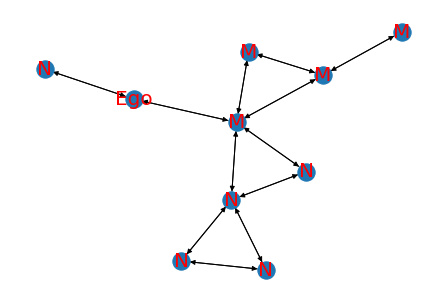

In [19]:
device = "cpu" #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = None  

dataset_train = utils.LocalExplanationsDataset("", adjs_train, edge_weights_train, "embeddings", transform=transform, y=le_classes_train, belonging=belonging_train, task_y=ori_classes_train, precomputed_embeddings=embeddings_train)
dataset_val = utils.LocalExplanationsDataset("", adjs_val, edge_weights_val, "embeddings", transform=transform, y=le_classes_val, belonging=belonging_val, task_y=ori_classes_val, precomputed_embeddings=embeddings_val)
dataset_test = utils.LocalExplanationsDataset("", adjs_test, edge_weights_test, "embeddings", transform=transform, y=le_classes_test, belonging=belonging_test, task_y=ori_classes_test, precomputed_embeddings=embeddings_test)


##
# debug Dataset
##
print(np.unique(le_classes_train, return_counts=True))
print(torch.unique(dataset_train.data.task_y, return_counts=True))
idx = 18
plot_etn(dataset_train[idx])
belonging_train[idx] , dataset_train[idx].graph_id

(array([0., 1., 3., 4., 5., 6., 7., 8.], dtype=float32), array([266, 125,  47,  63,  41,  10,  52, 105], dtype=int64))


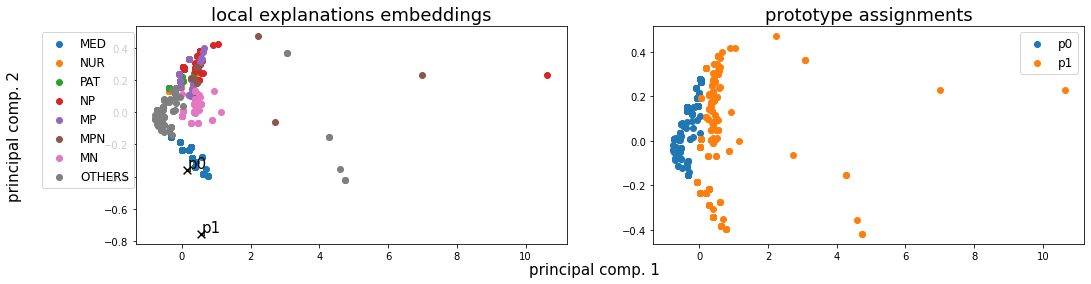

Alpha norms:
tensor([[1.0000, 0.6722],
        [0.7495, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.399753 +- 0.122399
Concept distribution:  (array([0, 1], dtype=int64), array([393, 316], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.26451, LEN: 0.086896, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.24751, V. LEN 0.09
  2: Loss: 0.22399, LEN: 0.086622, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.19870, V. LEN 0.09
  3: Loss: 0.16261, LEN: 0.086384, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.13785, V. LEN 0.09
  4: Loss: 0.12371, LEN: 0.086315, AccxC: 0.61, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.11887, V. LEN 0.09
  5: Loss: 0.11522, LEN: 0.086297, AccxC: 0.62, AccO: 0.03, V. Acc: 0.38, V. Loss: 0.11041, V. LEN 0.09
  6: Loss: 0.10841, LEN: 0.086222, AccxC: 0.61, AccO: 0.38, V. Acc: 0.38, V. Loss: 0.10750, V. LEN 0.09
  7: Loss: 0.10867, LEN: 0.086015, AccxC: 0.63, AccO:

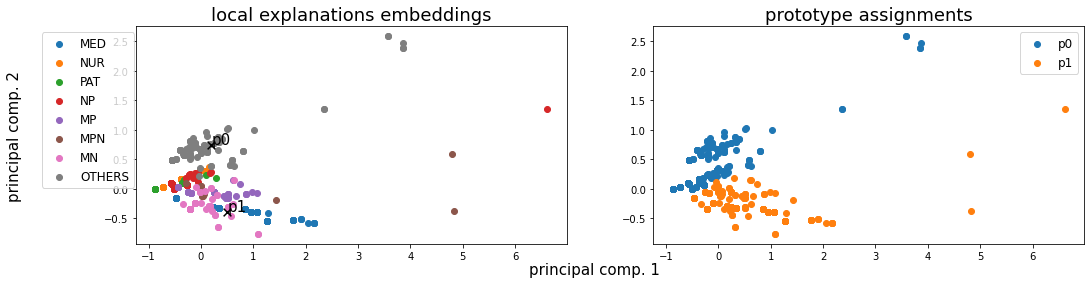

Alpha norms:
tensor([[1.0000, 0.5008],
        [0.7099, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.545604 +- 0.181172
Concept distribution:  (array([0, 1], dtype=int64), array([343, 366], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.8377997179125529 (feature001)
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.4683)


 20: Loss: 0.08810, LEN: 0.080923, AccxC: 0.79, AccO: 0.42, V. Acc: 0.38, V. Loss: 0.08575, V. LEN 0.08
 21: Loss: 0.08600, LEN: 0.079976, AccxC: 0.81, AccO: 0.44, V. Acc: 0.38, V. Loss: 0.08505, V. LEN 0.08
 22: Loss: 0.08547, LEN: 0.079376, AccxC: 0.82, AccO: 0.45, V. Acc: 0.36, V. Loss: 0.08484, V. LEN 0.08
 23: Loss: 0.08412, LEN: 0.078423, AccxC: 0.82, AccO: 0.75, V. Acc: 0.80, V. Loss: 0.08482, V. LEN 0.08
 24: Loss: 0.08516, LEN: 0.078329, AccxC: 0.80, AccO: 0.80, V. Acc: 0.80, V. Loss: 0.08404, V. LEN 0.08
 25: Loss: 0.08338, LEN: 0.077833, AccxC: 0.80, AccO: 0.80, V. Acc: 0.80, V. Loss: 0.08339, V. LEN 0.08
 26: Loss: 0.08347, LEN

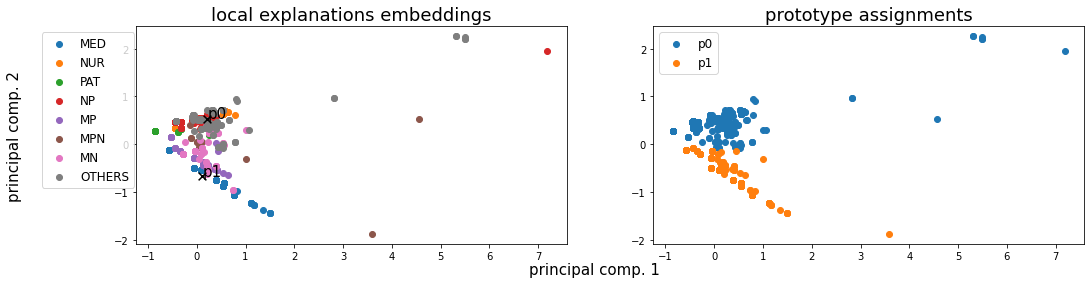

Alpha norms:
tensor([[1.0000, 0.5088],
        [0.6298, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.561955 +- 0.225028
Concept distribution:  (array([0, 1], dtype=int64), array([371, 338], dtype=int64))
Logic formulas:
For class 0:
0.8377997179125529 (feature000)
For class 1:
0.8377997179125529 (feature001)
Accuracy as classifier:  0.8378
LEN fidelity:  tensor(0.8378)


 40: Loss: 0.07171, LEN: 0.068068, AccxC: 0.82, AccO: 0.82, V. Acc: 0.80, V. Loss: 0.07097, V. LEN 0.07
 41: Loss: 0.06938, LEN: 0.066188, AccxC: 0.82, AccO: 0.82, V. Acc: 0.80, V. Loss: 0.06998, V. LEN 0.07
 42: Loss: 0.06861, LEN: 0.065180, AccxC: 0.83, AccO: 0.83, V. Acc: 0.80, V. Loss: 0.06976, V. LEN 0.07
 43: Loss: 0.06706, LEN: 0.063182, AccxC: 0.84, AccO: 0.84, V. Acc: 0.80, V. Loss: 0.07052, V. LEN 0.07
 44: Loss: 0.06546, LEN: 0.061596, AccxC: 0.85, AccO: 0.85, V. Acc: 0.80, V. Loss: 0.06915, V. LEN 0.07
 45: Loss: 0.06667, LEN: 0.063464, AccxC: 0.83, AccO: 0.83, V. Acc: 0.80, V. Loss: 0.06864, V. LEN 

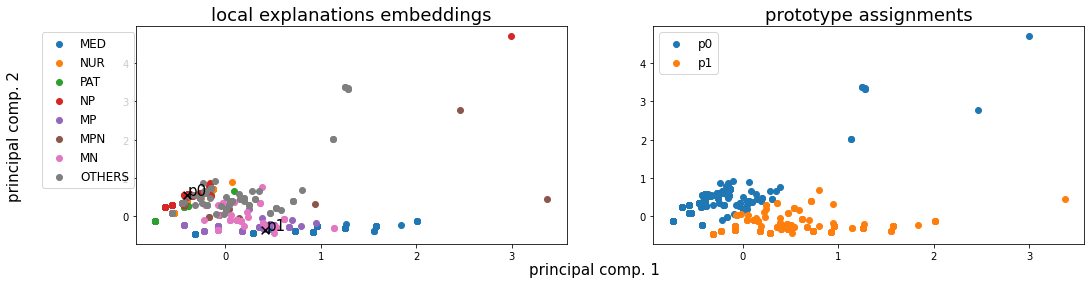

Alpha norms:
tensor([[1.0000, 0.5698],
        [0.3549, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.547027 +- 0.185755
Concept distribution:  (array([0, 1], dtype=int64), array([346, 363], dtype=int64))
Logic formulas:
For class 0:
0.8561354019746121 (feature000)
For class 1:
0.8561354019746121 (feature001)
Accuracy as classifier:  0.8561
LEN fidelity:  tensor(0.8561)


 60: Loss: 0.05715, LEN: 0.054942, AccxC: 0.85, AccO: 0.85, V. Acc: 0.80, V. Loss: 0.06292, V. LEN 0.06
 61: Loss: 0.05690, LEN: 0.053833, AccxC: 0.85, AccO: 0.85, V. Acc: 0.80, V. Loss: 0.06306, V. LEN 0.06
 62: Loss: 0.05591, LEN: 0.053328, AccxC: 0.85, AccO: 0.85, V. Acc: 0.80, V. Loss: 0.06249, V. LEN 0.06
 63: Loss: 0.05709, LEN: 0.054863, AccxC: 0.84, AccO: 0.84, V. Acc: 0.80, V. Loss: 0.06247, V. LEN 0.06
 64: Loss: 0.05642, LEN: 0.054017, AccxC: 0.85, AccO: 0.85, V. Acc: 0.82, V. Loss: 0.06023, V. LEN 0.06
 65: Loss: 0.05565, LEN: 0.053438, AccxC: 0.85, AccO: 0.85, V. Acc: 0.85, V. Loss: 0.05589, V. LEN 

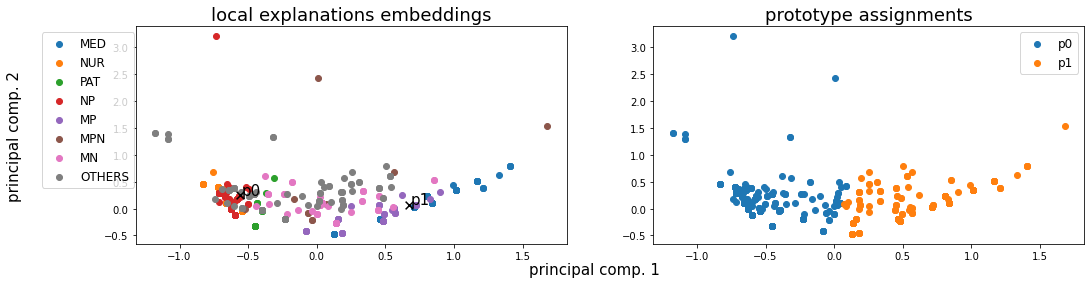

Alpha norms:
tensor([[1.0000, 0.5406],
        [0.2593, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.549571 +- 0.193446
Concept distribution:  (array([0, 1], dtype=int64), array([351, 358], dtype=int64))
Logic formulas:
For class 0:
0.8631875881523272 (feature000)
For class 1:
0.8631875881523272 (feature001)
Accuracy as classifier:  0.8632
LEN fidelity:  tensor(0.8632)


 80: Loss: 0.05089, LEN: 0.049923, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04801, V. LEN 0.05
 81: Loss: 0.05445, LEN: 0.053100, AccxC: 0.85, AccO: 0.85, V. Acc: 0.88, V. Loss: 0.04949, V. LEN 0.05
 82: Loss: 0.04798, LEN: 0.046871, AccxC: 0.88, AccO: 0.88, V. Acc: 0.89, V. Loss: 0.04648, V. LEN 0.05
 83: Loss: 0.04933, LEN: 0.047822, AccxC: 0.88, AccO: 0.88, V. Acc: 0.89, V. Loss: 0.04665, V. LEN 0.05
 84: Loss: 0.04976, LEN: 0.048410, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.04662, V. LEN 0.05
 85: Loss: 0.05005, LEN: 0.048732, AccxC: 0.86, AccO: 0.86, V. Acc: 0.89, V. Loss: 0.04637, V. LEN 

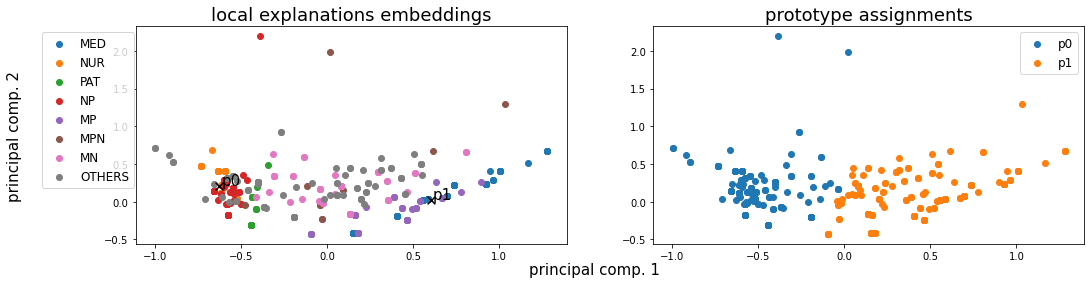

Alpha norms:
tensor([[1.0000, 0.5000],
        [0.2436, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.536950 +- 0.145101
Concept distribution:  (array([0, 1], dtype=int64), array([319, 390], dtype=int64))
Logic formulas:
For class 0:
0.8942172073342737 (feature000)
For class 1:
0.8942172073342737 (feature001)
Accuracy as classifier:  0.8942
LEN fidelity:  tensor(0.8942)


100: Loss: 0.05085, LEN: 0.049806, AccxC: 0.87, AccO: 0.87, V. Acc: 0.92, V. Loss: 0.03811, V. LEN 0.04
101: Loss: 0.04891, LEN: 0.047895, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03844, V. LEN 0.04
102: Loss: 0.04762, LEN: 0.046691, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03827, V. LEN 0.04
103: Loss: 0.04819, LEN: 0.047297, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03811, V. LEN 0.04
104: Loss: 0.04741, LEN: 0.046481, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03763, V. LEN 0.04
105: Loss: 0.04622, LEN: 0.045222, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03745, V. LEN 

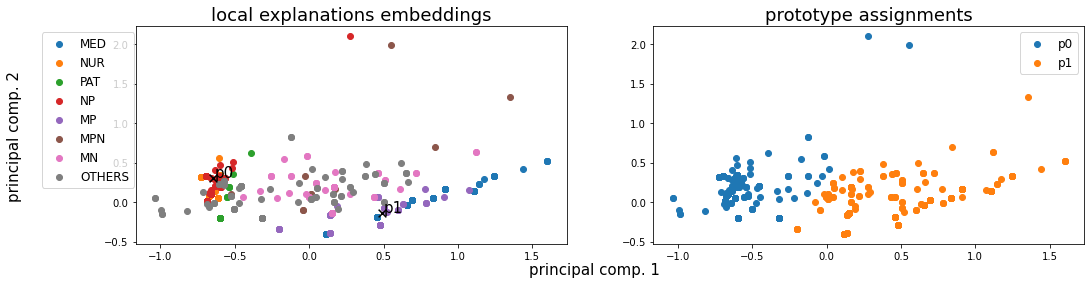

Alpha norms:
tensor([[1.0000, 0.4945],
        [0.2474, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.536447 +- 0.142125
Concept distribution:  (array([0, 1], dtype=int64), array([317, 392], dtype=int64))
Logic formulas:
For class 0:
0.8942172073342737 (feature000)
For class 1:
0.8942172073342737 (feature001)
Accuracy as classifier:  0.8942
LEN fidelity:  tensor(0.8942)


120: Loss: 0.04846, LEN: 0.047172, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04224, V. LEN 0.04
121: Loss: 0.04945, LEN: 0.048574, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04224, V. LEN 0.04
122: Loss: 0.04653, LEN: 0.045642, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04071, V. LEN 0.04
123: Loss: 0.04653, LEN: 0.045355, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04051, V. LEN 0.04
124: Loss: 0.04821, LEN: 0.047269, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03752, V. LEN 0.04
125: Loss: 0.04930, LEN: 0.048294, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03826, V. LEN 

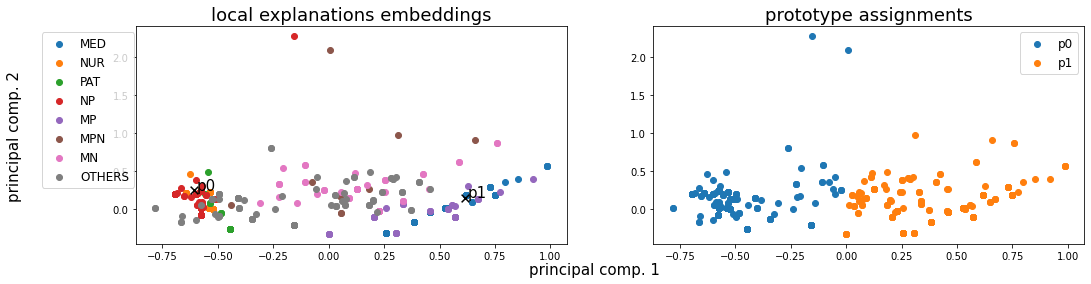

Alpha norms:
tensor([[1.0000, 0.4992],
        [0.2352, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.537215 +- 0.146590
Concept distribution:  (array([0, 1], dtype=int64), array([320, 389], dtype=int64))
Logic formulas:
For class 0:
0.8956276445698167 (feature000)
For class 1:
0.8956276445698167 (feature001)
Accuracy as classifier:  0.8956
LEN fidelity:  tensor(0.8956)


140: Loss: 0.04649, LEN: 0.045683, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03735, V. LEN 0.04
141: Loss: 0.04458, LEN: 0.043765, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03748, V. LEN 0.04
142: Loss: 0.04502, LEN: 0.044224, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04218, V. LEN 0.04
143: Loss: 0.04615, LEN: 0.045143, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04188, V. LEN 0.04
144: Loss: 0.04621, LEN: 0.045296, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03709, V. LEN 0.04
145: Loss: 0.04457, LEN: 0.043980, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03696, V. LEN 

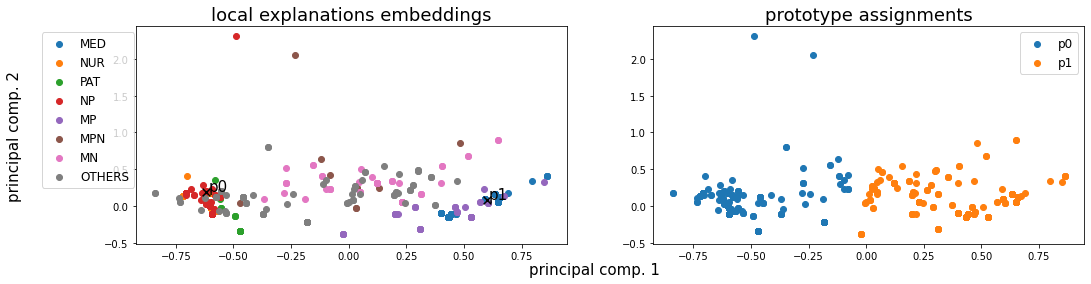

Alpha norms:
tensor([[1.0000, 0.4935],
        [0.2336, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.537488 +- 0.148079
Concept distribution:  (array([0, 1], dtype=int64), array([321, 388], dtype=int64))
Logic formulas:
For class 0:
0.8970380818053597 (feature000)
For class 1:
0.8970380818053597 (feature001)
Accuracy as classifier:  0.897
LEN fidelity:  tensor(0.8970)


160: Loss: 0.04580, LEN: 0.045317, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03702, V. LEN 0.04
161: Loss: 0.04500, LEN: 0.044617, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03694, V. LEN 0.04
162: Loss: 0.04579, LEN: 0.045360, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03696, V. LEN 0.04
163: Loss: 0.04596, LEN: 0.045610, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03693, V. LEN 0.04
164: Loss: 0.04571, LEN: 0.045378, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03688, V. LEN 0.04
165: Loss: 0.04553, LEN: 0.044998, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03700, V. LEN 0

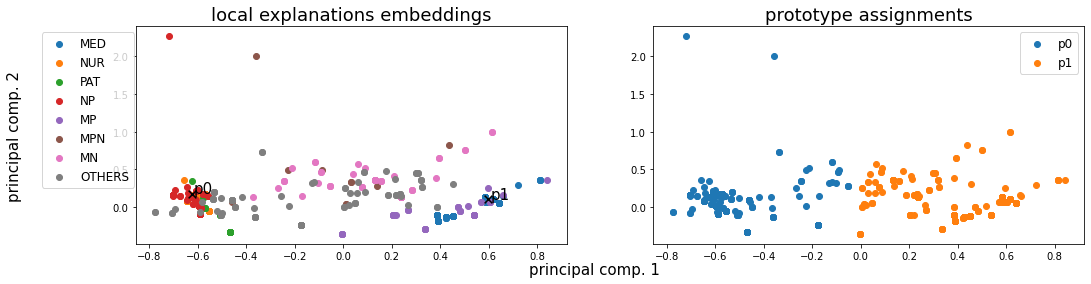

Alpha norms:
tensor([[1.0000, 0.4873],
        [0.2324, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.537488 +- 0.148079
Concept distribution:  (array([0, 1], dtype=int64), array([321, 388], dtype=int64))
Logic formulas:
For class 0:
0.8970380818053597 (feature000)
For class 1:
0.8970380818053597 (feature001)
Accuracy as classifier:  0.897
LEN fidelity:  tensor(0.8970)


180: Loss: 0.04611, LEN: 0.045746, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03651, V. LEN 0.04
181: Loss: 0.04649, LEN: 0.046131, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03650, V. LEN 0.04
182: Loss: 0.04421, LEN: 0.043875, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03653, V. LEN 0.04
183: Loss: 0.04527, LEN: 0.044904, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03669, V. LEN 0.04
184: Loss: 0.04573, LEN: 0.045329, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03665, V. LEN 0.04
185: Loss: 0.04572, LEN: 0.045183, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03667, V. LEN 0

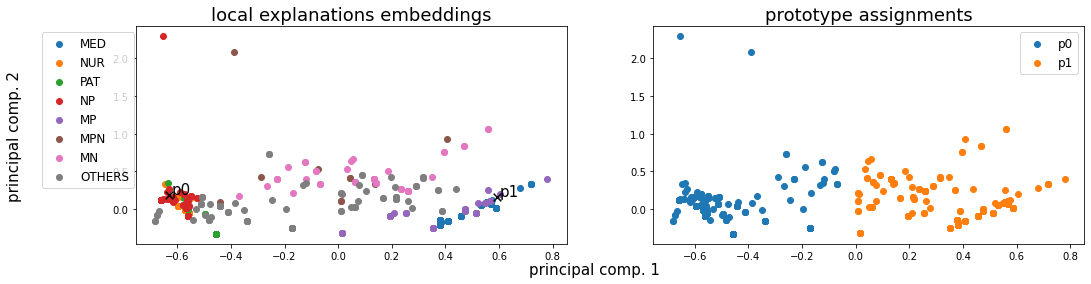

Alpha norms:
tensor([[1.0000, 0.4926],
        [0.2298, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.537488 +- 0.148079
Concept distribution:  (array([0, 1], dtype=int64), array([321, 388], dtype=int64))
Logic formulas:
For class 0:
0.8970380818053597 (feature000)
For class 1:
0.8970380818053597 (feature001)
Accuracy as classifier:  0.897
LEN fidelity:  tensor(0.8970)


200: Loss: 0.04681, LEN: 0.046325, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03682, V. LEN 0.04
201: Loss: 0.04428, LEN: 0.043875, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03707, V. LEN 0.04
202: Loss: 0.04448, LEN: 0.043958, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03708, V. LEN 0.04
203: Loss: 0.04435, LEN: 0.043967, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03677, V. LEN 0.04
204: Loss: 0.04855, LEN: 0.048153, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03668, V. LEN 0.04
205: Loss: 0.04326, LEN: 0.042894, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03696, V. LEN 0

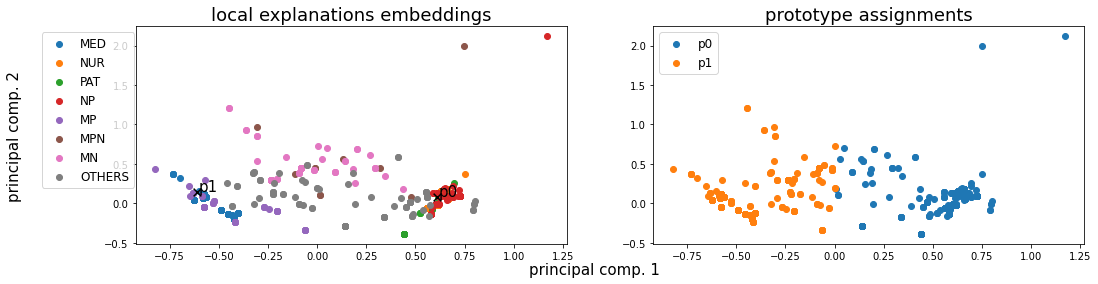

Alpha norms:
tensor([[1.0000, 0.4843],
        [0.2311, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.538976 +- 0.155541
Concept distribution:  (array([0, 1], dtype=int64), array([326, 383], dtype=int64))
Logic formulas:
For class 0:
0.8956276445698167 (feature000)
For class 1:
0.8956276445698167 (feature001)
Accuracy as classifier:  0.8956
LEN fidelity:  tensor(0.8956)


220: Loss: 0.04573, LEN: 0.045350, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03664, V. LEN 0.04
221: Loss: 0.04471, LEN: 0.044221, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03655, V. LEN 0.04
222: Loss: 0.04625, LEN: 0.045810, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03674, V. LEN 0.04
223: Loss: 0.04582, LEN: 0.045441, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03684, V. LEN 0.04
224: Loss: 0.04626, LEN: 0.045796, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03688, V. LEN 0.04
225: Loss: 0.04641, LEN: 0.046065, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03704, V. LEN 

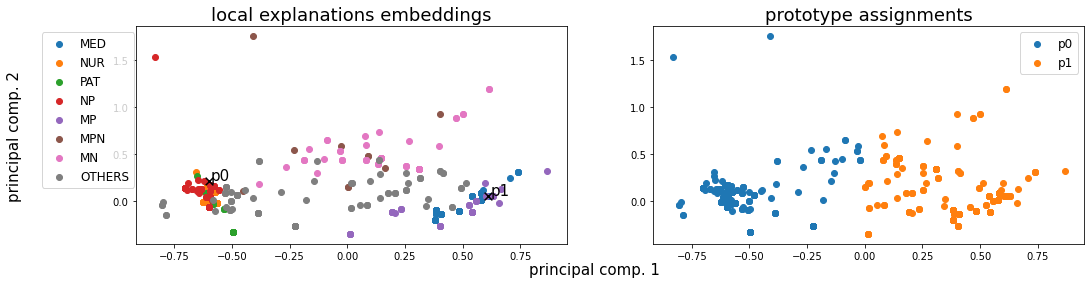

Alpha norms:
tensor([[1.0000, 0.4836],
        [0.2317, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.537488 +- 0.148079
Concept distribution:  (array([0, 1], dtype=int64), array([321, 388], dtype=int64))
Logic formulas:
For class 0:
0.8970380818053597 (feature000)
For class 1:
0.8970380818053597 (feature001)
Accuracy as classifier:  0.897
LEN fidelity:  tensor(0.8970)


240: Loss: 0.04178, LEN: 0.041394, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03654, V. LEN 0.04
241: Loss: 0.04508, LEN: 0.044778, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03727, V. LEN 0.04
242: Loss: 0.04604, LEN: 0.045622, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03666, V. LEN 0.04
243: Loss: 0.04387, LEN: 0.043532, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03641, V. LEN 0.04
244: Loss: 0.04525, LEN: 0.044920, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03662, V. LEN 0.04
245: Loss: 0.04340, LEN: 0.043101, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03674, V. LEN 0

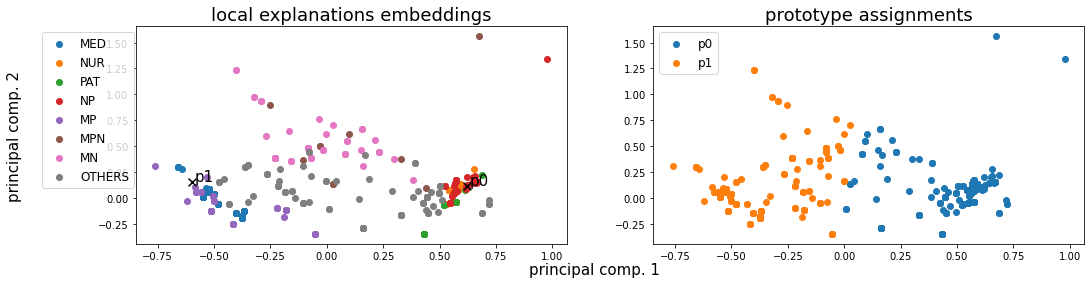

Alpha norms:
tensor([[1.0000, 0.4921],
        [0.2254, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.538976 +- 0.155541
Concept distribution:  (array([0, 1], dtype=int64), array([326, 383], dtype=int64))
Logic formulas:
For class 0:
0.8984485190409027 (feature000)
For class 1:
0.8984485190409027 (feature001)
Accuracy as classifier:  0.8984
LEN fidelity:  tensor(0.8984)


260: Loss: 0.04605, LEN: 0.045675, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03676, V. LEN 0.04
261: Loss: 0.04393, LEN: 0.043609, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03660, V. LEN 0.04
262: Loss: 0.04259, LEN: 0.042261, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03667, V. LEN 0.04
263: Loss: 0.04446, LEN: 0.044135, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03722, V. LEN 0.04
264: Loss: 0.04611, LEN: 0.045696, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03674, V. LEN 0.04
265: Loss: 0.04518, LEN: 0.044912, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03641, V. LEN 

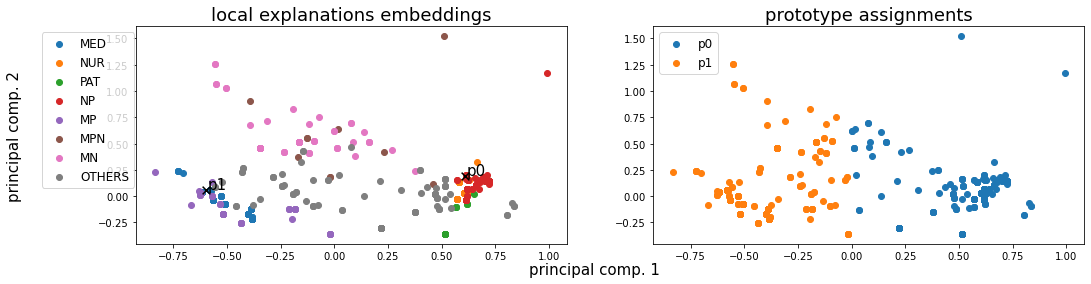

Alpha norms:
tensor([[1.0000, 0.4908],
        [0.2268, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.538356 +- 0.152553
Concept distribution:  (array([0, 1], dtype=int64), array([324, 385], dtype=int64))
Logic formulas:
For class 0:
0.8984485190409027 (feature000)
For class 1:
0.8984485190409027 (feature001)
Accuracy as classifier:  0.8984
LEN fidelity:  tensor(0.8984)


280: Loss: 0.04405, LEN: 0.043755, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03644, V. LEN 0.04
281: Loss: 0.04238, LEN: 0.041979, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03654, V. LEN 0.04
282: Loss: 0.04381, LEN: 0.043450, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03654, V. LEN 0.04
283: Loss: 0.04353, LEN: 0.043235, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03660, V. LEN 0.04
284: Loss: 0.04484, LEN: 0.044454, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03657, V. LEN 0.04
285: Loss: 0.04562, LEN: 0.045304, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03640, V. LEN 

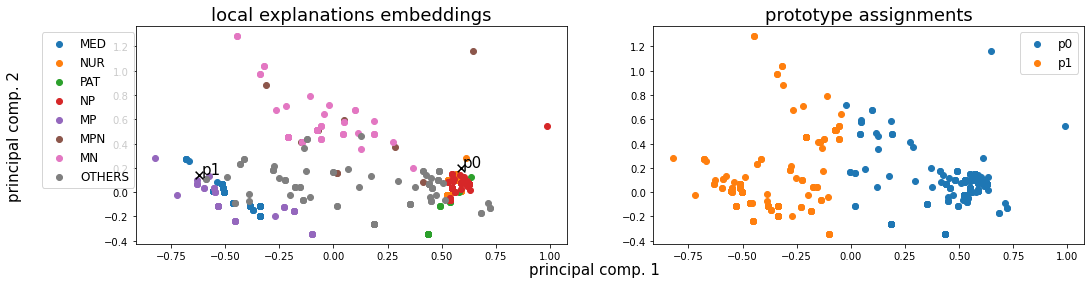

Alpha norms:
tensor([[1.0000, 0.4854],
        [0.2193, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.539970 +- 0.160030
Concept distribution:  (array([0, 1], dtype=int64), array([329, 380], dtype=int64))
Logic formulas:
For class 0:
0.8942172073342737 (feature000)
For class 1:
0.8942172073342737 (feature001)
Accuracy as classifier:  0.8942
LEN fidelity:  tensor(0.8942)


300: Loss: 0.04531, LEN: 0.044984, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03707, V. LEN 0.04
301: Loss: 0.04464, LEN: 0.044196, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03653, V. LEN 0.04
302: Loss: 0.04279, LEN: 0.042469, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03673, V. LEN 0.04
303: Loss: 0.04377, LEN: 0.043429, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03666, V. LEN 0.04
304: Loss: 0.04154, LEN: 0.041201, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03657, V. LEN 0.04
305: Loss: 0.04374, LEN: 0.043440, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03644, V. LEN 

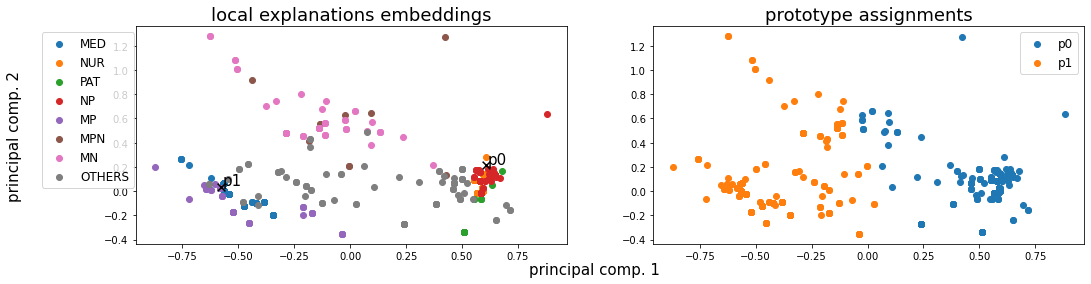

Alpha norms:
tensor([[1.0000, 0.4863],
        [0.2153, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.537769 +- 0.149570
Concept distribution:  (array([0, 1], dtype=int64), array([322, 387], dtype=int64))
Logic formulas:
For class 0:
0.8984485190409027 (feature000)
For class 1:
0.8984485190409027 (feature001)
Accuracy as classifier:  0.8984
LEN fidelity:  tensor(0.8984)


320: Loss: 0.04365, LEN: 0.043291, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03670, V. LEN 0.04
321: Loss: 0.04465, LEN: 0.044263, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04138, V. LEN 0.04
322: Loss: 0.04469, LEN: 0.044345, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03635, V. LEN 0.04
323: Loss: 0.04635, LEN: 0.045961, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03641, V. LEN 0.04
324: Loss: 0.04445, LEN: 0.044118, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03665, V. LEN 0.04
325: Loss: 0.04416, LEN: 0.043839, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03694, V. LEN 

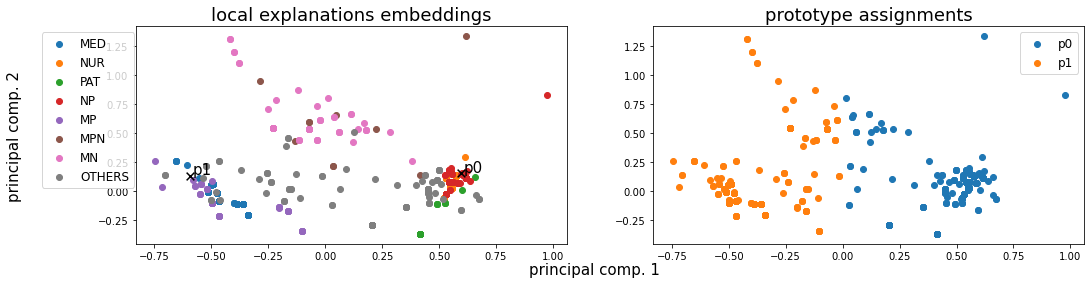

Alpha norms:
tensor([[1.0000, 0.4806],
        [0.2208, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.539299 +- 0.157036
Concept distribution:  (array([0, 1], dtype=int64), array([327, 382], dtype=int64))
Logic formulas:
For class 0:
0.8970380818053597 (feature000)
For class 1:
0.8970380818053597 (feature001)
Accuracy as classifier:  0.897
LEN fidelity:  tensor(0.8970)


340: Loss: 0.04797, LEN: 0.047731, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03670, V. LEN 0.04
341: Loss: 0.04366, LEN: 0.043284, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03720, V. LEN 0.04
342: Loss: 0.04458, LEN: 0.044178, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03784, V. LEN 0.04
343: Loss: 0.04553, LEN: 0.045080, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03680, V. LEN 0.04
344: Loss: 0.04184, LEN: 0.041409, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03653, V. LEN 0.04
345: Loss: 0.04464, LEN: 0.044257, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03643, V. LEN 0

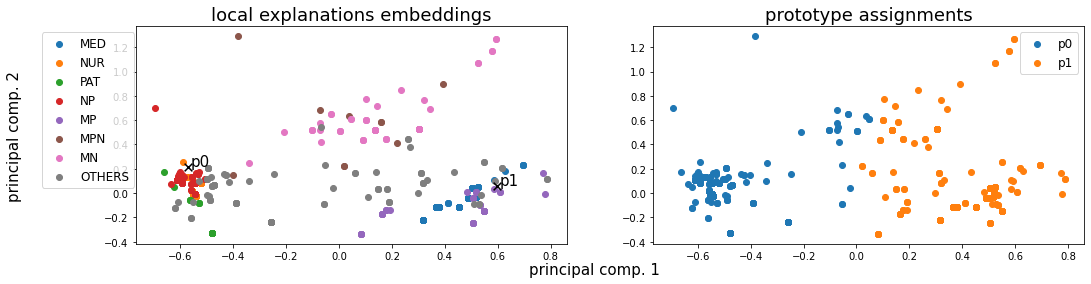

Alpha norms:
tensor([[1.0000, 0.4833],
        [0.2200, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.538356 +- 0.152553
Concept distribution:  (array([0, 1], dtype=int64), array([324, 385], dtype=int64))
Logic formulas:
For class 0:
0.8984485190409027 (feature000)
For class 1:
0.8984485190409027 (feature001)
Accuracy as classifier:  0.8984
LEN fidelity:  tensor(0.8984)


360: Loss: 0.04476, LEN: 0.044471, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03676, V. LEN 0.04
361: Loss: 0.04199, LEN: 0.041692, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03647, V. LEN 0.04
362: Loss: 0.04362, LEN: 0.043332, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03637, V. LEN 0.04
363: Loss: 0.04520, LEN: 0.044989, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03647, V. LEN 0.04
364: Loss: 0.04477, LEN: 0.044548, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03652, V. LEN 0.04
365: Loss: 0.04231, LEN: 0.042105, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03644, V. LEN 

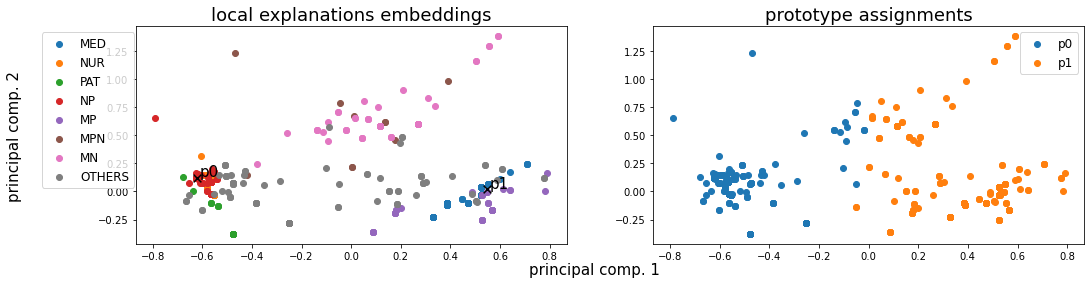

Alpha norms:
tensor([[1.0000, 0.4810],
        [0.2227, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.536950 +- 0.145101
Concept distribution:  (array([0, 1], dtype=int64), array([319, 390], dtype=int64))
Logic formulas:
For class 0:
0.9026798307475318 (feature000)
For class 1:
0.9026798307475318 (feature001)
Accuracy as classifier:  0.9027
LEN fidelity:  tensor(0.9027)


380: Loss: 0.04296, LEN: 0.042636, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03625, V. LEN 0.04
381: Loss: 0.04355, LEN: 0.043265, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03631, V. LEN 0.04
382: Loss: 0.04186, LEN: 0.041541, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03641, V. LEN 0.04
383: Loss: 0.04505, LEN: 0.044786, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03613, V. LEN 0.04
384: Loss: 0.04529, LEN: 0.044999, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03635, V. LEN 0.04
385: Loss: 0.04538, LEN: 0.045079, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03630, V. LEN 

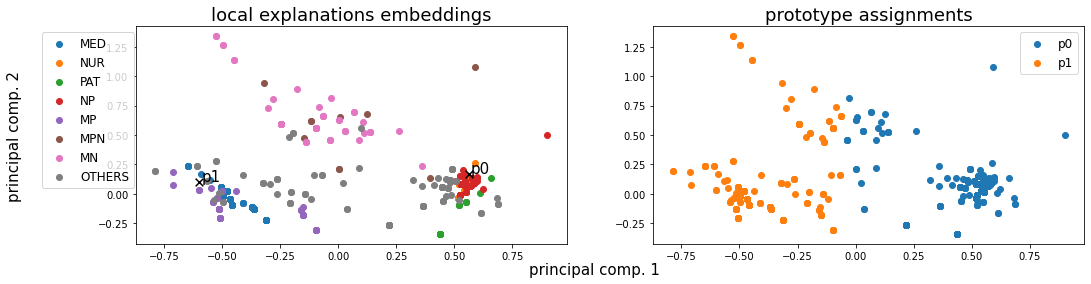

Alpha norms:
tensor([[1.0000, 0.4812],
        [0.2236, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.540317 +- 0.161530
Concept distribution:  (array([0, 1], dtype=int64), array([330, 379], dtype=int64))
Logic formulas:
For class 0:
0.8984485190409027 (feature000)
For class 1:
0.8984485190409027 (feature001)
Accuracy as classifier:  0.8984
LEN fidelity:  tensor(0.8984)


400: Loss: 0.04270, LEN: 0.042352, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03634, V. LEN 0.04
401: Loss: 0.04318, LEN: 0.042901, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03622, V. LEN 0.04
402: Loss: 0.04446, LEN: 0.044235, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03632, V. LEN 0.04
403: Loss: 0.04523, LEN: 0.044998, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03623, V. LEN 0.04
404: Loss: 0.04533, LEN: 0.045113, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03628, V. LEN 0.04
405: Loss: 0.04182, LEN: 0.041588, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03632, V. LEN 

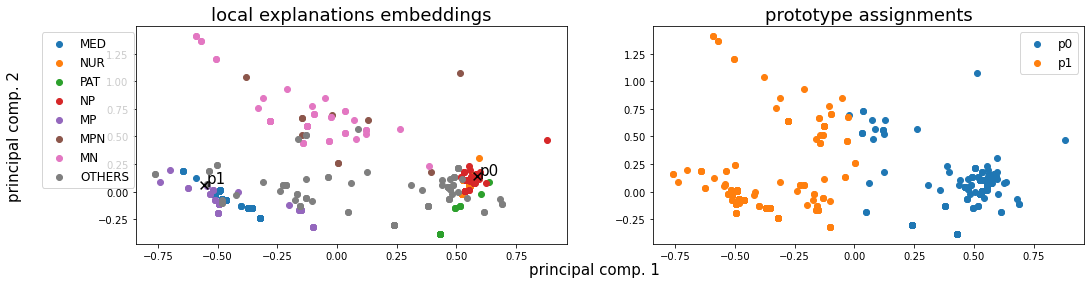

Alpha norms:
tensor([[1.0000, 0.4809],
        [0.2238, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.537769 +- 0.149570
Concept distribution:  (array([0, 1], dtype=int64), array([322, 387], dtype=int64))
Logic formulas:
For class 0:
0.9012693935119888 (feature000)
For class 1:
0.9012693935119888 (feature001)
Accuracy as classifier:  0.9013
LEN fidelity:  tensor(0.9013)


420: Loss: 0.04448, LEN: 0.044221, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03642, V. LEN 0.04
421: Loss: 0.04303, LEN: 0.042774, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03629, V. LEN 0.04
422: Loss: 0.04299, LEN: 0.042731, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03629, V. LEN 0.04
423: Loss: 0.04326, LEN: 0.043034, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03673, V. LEN 0.04
424: Loss: 0.04370, LEN: 0.043417, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03640, V. LEN 0.04
425: Loss: 0.04281, LEN: 0.042608, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03638, V. LEN 

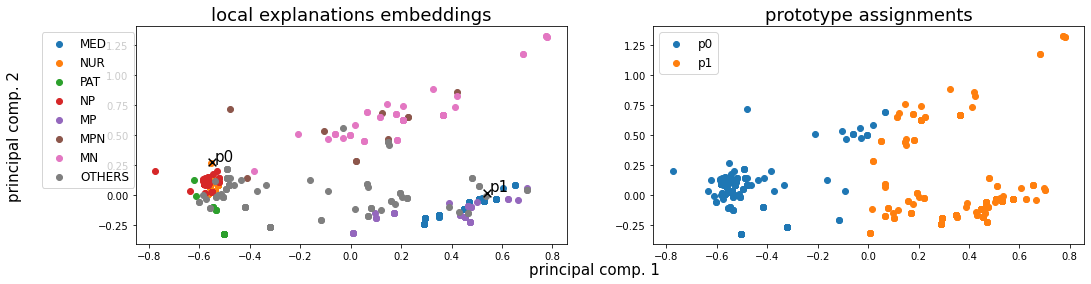

Alpha norms:
tensor([[1.0000, 0.4815],
        [0.2241, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.537488 +- 0.148079
Concept distribution:  (array([0, 1], dtype=int64), array([321, 388], dtype=int64))
Logic formulas:
For class 0:
0.9026798307475318 (feature000)
For class 1:
0.9026798307475318 (feature001)
Accuracy as classifier:  0.9027
LEN fidelity:  tensor(0.9027)


440: Loss: 0.04208, LEN: 0.041747, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03737, V. LEN 0.04
441: Loss: 0.04331, LEN: 0.042990, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03631, V. LEN 0.04
442: Loss: 0.04534, LEN: 0.045019, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03623, V. LEN 0.04
443: Loss: 0.04220, LEN: 0.041937, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03624, V. LEN 0.04
444: Loss: 0.04312, LEN: 0.042783, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03647, V. LEN 0.04
445: Loss: 0.04195, LEN: 0.041604, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03622, V. LEN 

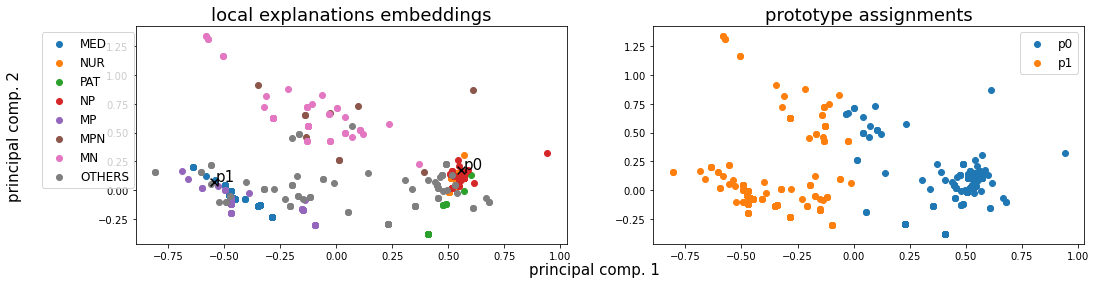

Alpha norms:
tensor([[1.0000, 0.4792],
        [0.2259, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.538662 +- 0.154046
Concept distribution:  (array([0, 1], dtype=int64), array([325, 384], dtype=int64))
Logic formulas:
For class 0:
0.8998589562764457 (feature000)
For class 1:
0.8998589562764457 (feature001)
Accuracy as classifier:  0.8999
LEN fidelity:  tensor(0.8999)


460: Loss: 0.04166, LEN: 0.041391, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03612, V. LEN 0.04
461: Loss: 0.04426, LEN: 0.044024, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03611, V. LEN 0.04
462: Loss: 0.04362, LEN: 0.043316, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03602, V. LEN 0.04
463: Loss: 0.04359, LEN: 0.043374, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03623, V. LEN 0.04
464: Loss: 0.04565, LEN: 0.045428, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03632, V. LEN 0.04
465: Loss: 0.04254, LEN: 0.042348, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03610, V. LEN 

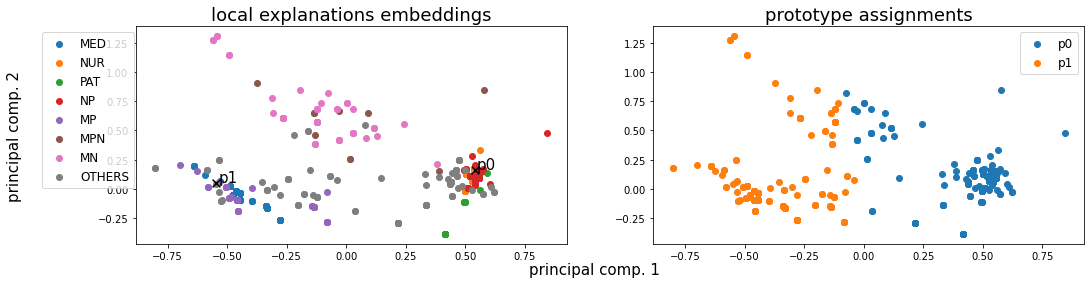

Alpha norms:
tensor([[1.0000, 0.4776],
        [0.2248, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.539970 +- 0.160030
Concept distribution:  (array([0, 1], dtype=int64), array([329, 380], dtype=int64))
Logic formulas:
For class 0:
0.8998589562764457 (feature000)
For class 1:
0.8998589562764457 (feature001)
Accuracy as classifier:  0.8999
LEN fidelity:  tensor(0.8999)


480: Loss: 0.04198, LEN: 0.041746, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03608, V. LEN 0.04
481: Loss: 0.04591, LEN: 0.045649, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03608, V. LEN 0.04
482: Loss: 0.04335, LEN: 0.043096, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03610, V. LEN 0.04
483: Loss: 0.04429, LEN: 0.044046, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03620, V. LEN 0.04
484: Loss: 0.04480, LEN: 0.044538, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03609, V. LEN 0.04
485: Loss: 0.04281, LEN: 0.042518, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03634, V. LEN 

FileNotFoundError: [Errno 2] No such file or directory: '../logs/ablation/confidence_intervals/ETN/MUTAG 2prots  no attn_train_metrics.pkl'

In [13]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)



torch.manual_seed(42)
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 2,
    "dim_prototypes": 10,
    "num_le_features": 5,
    "activation": "leaky",
    "embedder_backbone": "GIN",
    "embedder_num_layers": 2,
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": True,
    "num_epochs": 500,
}

len_model    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"],
                                 backbone=hyper["embedder_backbone"],
                                 num_layers=hyper["embedder_num_layers"]).to(device)
expl         = models.GlobalExplainer(len_model, 
                                   le_model, 
                                   train_group_loader, 
                                   val_group_loader, 
                                   device, 
                                   hyper_params=hyper,
                                   classes_names=priori_etn_classes_names,
                                   dataset_name="ETN").to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
suffix = "no attn" if hyper["remove_attention"] else ""
expl.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb=f"MUTAG {hyper['num_prototypes']}prots {prefix} {suffix}")

In [14]:
x_train , emb , concepts_assignement , y_train_1h , le_classes , le_idxs , belonging = expl.get_concept_vector(train_group_loader, 
                                                                                                               return_raw=True)        

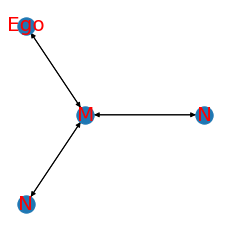

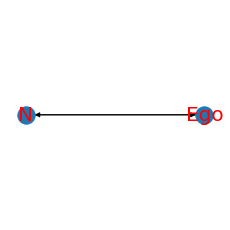

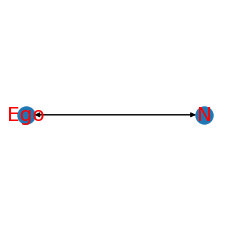

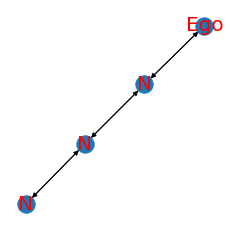

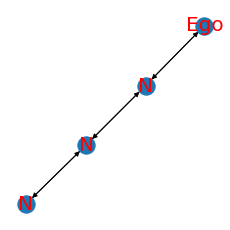

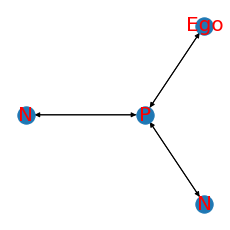

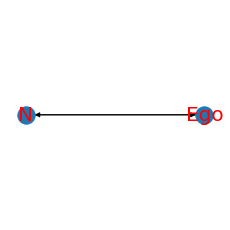

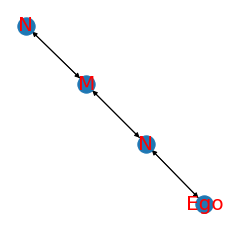

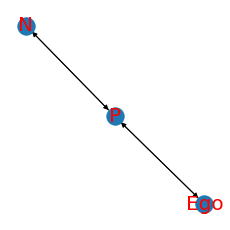

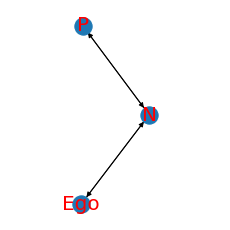

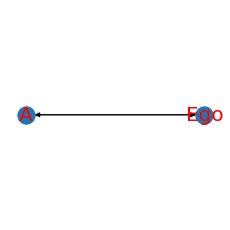

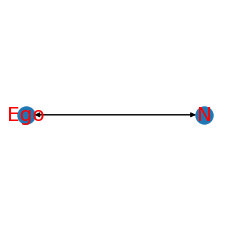

In [15]:
idxs = le_idxs[concepts_assignement.argmax(-1) == 0]
for idx in idxs[:12]: 
    plt.figure(figsize=(3,3))
    plot_etn(dataset_train[int(idx)])
    plt.show()

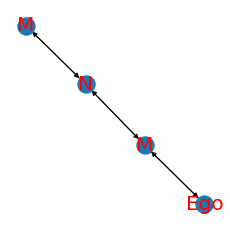

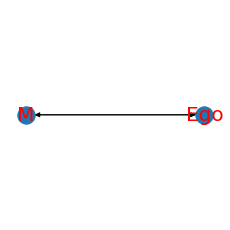

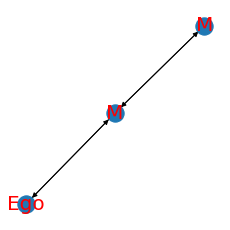

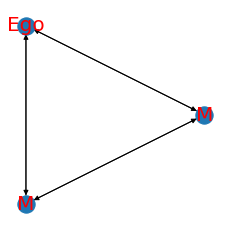

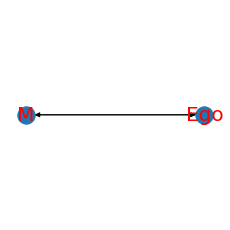

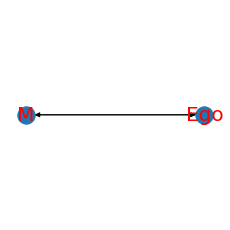

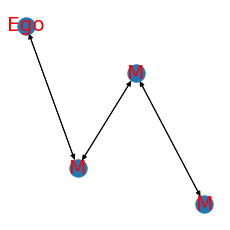

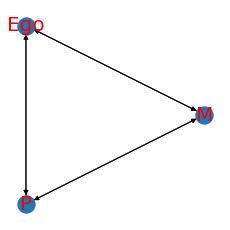

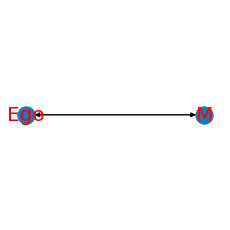

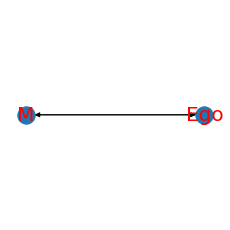

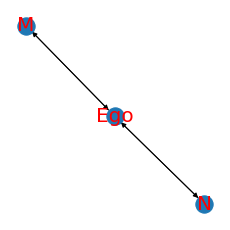

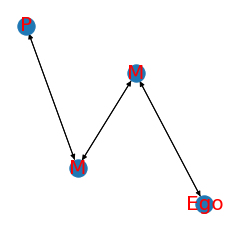

In [16]:
idxs = le_idxs[concepts_assignement.argmax(-1) == 1]
for idx in idxs[:12]: 
    plt.figure(figsize=(3,3))
    plot_etn(dataset_train[int(idx)])
    plt.show()

(array([0., 1., 2., 3., 4., 5., 6., 7., 8.], dtype=float32), array([ 46,  16, 433,   5, 113,  29, 234,  58, 316], dtype=int64))


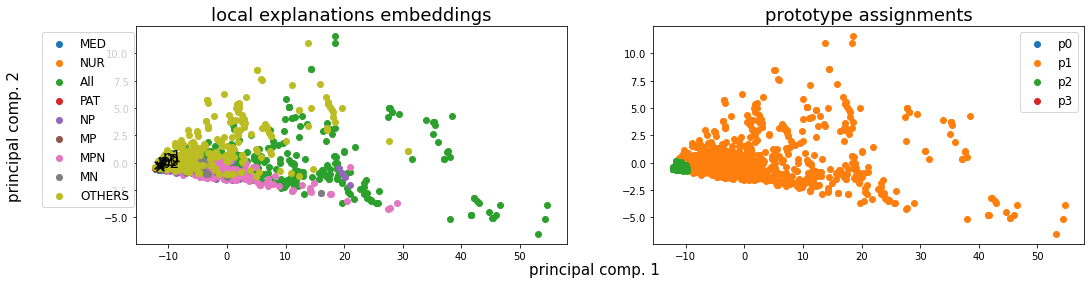

Alpha norms:
tensor([[1.0000, 0.8459, 0.8427, 0.9224],
        [0.8005, 0.7799, 1.0000, 0.8565]], grad_fn=<DivBackward0>)
Concept Purity: 0.389102 +- 0.047969
Concept distribution:  (array([0, 1, 2], dtype=int64), array([  11, 1151,   88], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.40974, LEN: 0.097602, AccxC: 0.48, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.28907, V. LEN 0.10
  2: Loss: 0.24916, LEN: 0.096540, AccxC: 0.48, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.18516, V. LEN 0.10
  3: Loss: 0.19621, LEN: 0.095675, AccxC: 0.50, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.18085, V. LEN 0.10
  4: Loss: 0.17460, LEN: 0.095041, AccxC: 0.50, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.15007, V. LEN 0.09
  5: Loss: 0.15565, LEN: 0.094248, AccxC: 0.50, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.13973, V. LEN 0.09
  6: Loss: 0.14393, LEN: 0.093485, AccxC: 0.50, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.12670, V. LEN 0.09
  7: Loss:

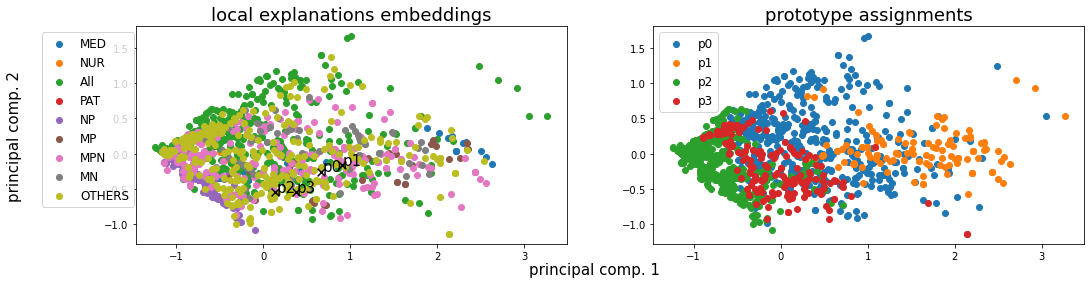

Alpha norms:
tensor([[1.0000, 0.4572, 0.5653, 0.5329],
        [0.7572, 0.7710, 1.0000, 0.7765]], grad_fn=<DivBackward0>)
Concept Purity: 0.488465 +- 0.137554
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([427, 126, 511, 186], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)


 20: Loss: 0.10983, LEN: 0.086627, AccxC: 0.59, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.10377, V. LEN 0.09
 21: Loss: 0.10823, LEN: 0.086381, AccxC: 0.65, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.10266, V. LEN 0.09
 22: Loss: 0.10722, LEN: 0.085994, AccxC: 0.66, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.10337, V. LEN 0.09
 23: Loss: 0.10649, LEN: 0.085724, AccxC: 0.66, AccO: 0.06, V. Acc: 0.21, V. Loss: 0.10367, V. LEN 0.08
 24: Loss: 0.10381, LEN: 0.085459, AccxC: 0.66, AccO: 0.20, V. Acc: 0.26, V. Loss: 0.09893, V. LEN 0.08
 25: Loss: 0.10364, LEN: 0.085352, AccxC: 0.64, AccO: 0.21, V. Acc: 0.27, V. Loss: 0.09880, V. LEN 0.08
 26:

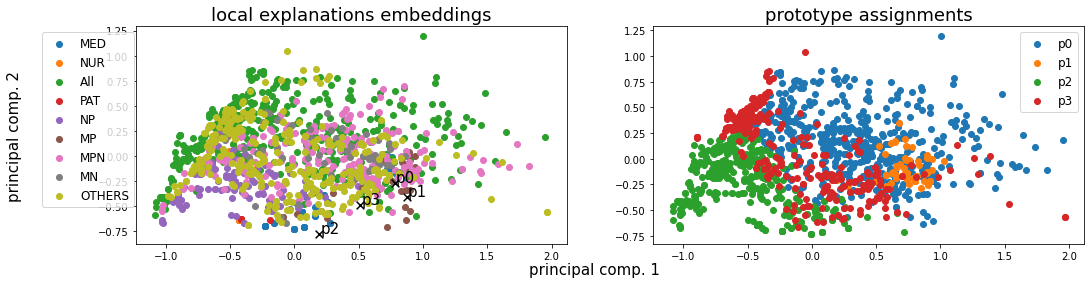

Alpha norms:
tensor([[1.0000, 0.7300, 0.4330, 0.8523],
        [0.4012, 0.8073, 0.8604, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.427310 +- 0.119800
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([521,  64, 391, 274], dtype=int64))
Logic formulas:
For class 0:
0.6664 ((feature002) | (feature003)
For class 1:
0.6664 ((feature000) | (feature001)
Accuracy as classifier:  0.6664
LEN fidelity:  tensor(0.6664)


 40: Loss: 0.09366, LEN: 0.083067, AccxC: 0.65, AccO: 0.65, V. Acc: 0.73, V. Loss: 0.09327, V. LEN 0.08
 41: Loss: 0.09464, LEN: 0.083304, AccxC: 0.64, AccO: 0.64, V. Acc: 0.71, V. Loss: 0.09064, V. LEN 0.08
 42: Loss: 0.09307, LEN: 0.082864, AccxC: 0.64, AccO: 0.64, V. Acc: 0.67, V. Loss: 0.09168, V. LEN 0.08
 43: Loss: 0.09352, LEN: 0.083161, AccxC: 0.62, AccO: 0.62, V. Acc: 0.64, V. Loss: 0.09421, V. LEN 0.08
 44: Loss: 0.09314, LEN: 0.083355, AccxC: 0.62, AccO: 0.62, V. Acc: 0.69, V. Loss: 0.09217, V. LEN 0.08
 45: Loss: 0.09213, LEN: 0.083122, AccxC: 0

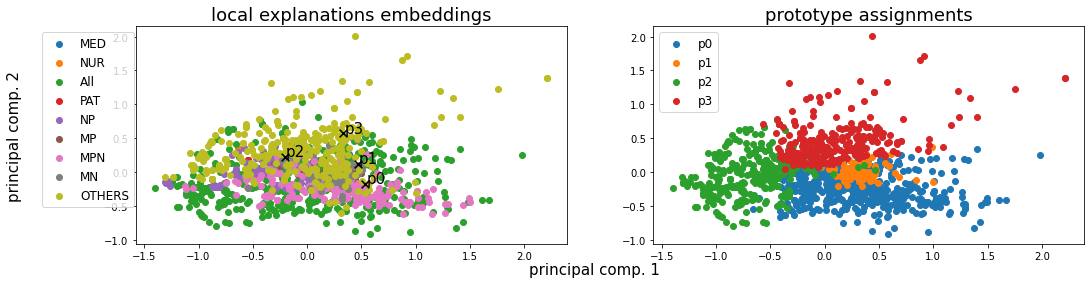

Alpha norms:
tensor([[0.5074, 1.0000, 0.2810, 0.9204],
        [0.2496, 0.9682, 0.5528, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.433320 +- 0.072368
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([517,  93, 361, 279], dtype=int64))
Logic formulas:
For class 0:
0.6592 (feature003) | ((feature002)
For class 1:
0.6592 ((feature000) | (feature001)
Accuracy as classifier:  0.6592
LEN fidelity:  tensor(0.6592)


 60: Loss: 0.08713, LEN: 0.080358, AccxC: 0.64, AccO: 0.64, V. Acc: 0.73, V. Loss: 0.08315, V. LEN 0.08
 61: Loss: 0.08460, LEN: 0.078877, AccxC: 0.66, AccO: 0.66, V. Acc: 0.69, V. Loss: 0.08072, V. LEN 0.08
 62: Loss: 0.08439, LEN: 0.078215, AccxC: 0.67, AccO: 0.67, V. Acc: 0.71, V. Loss: 0.07874, V. LEN 0.07
 63: Loss: 0.08473, LEN: 0.079277, AccxC: 0.64, AccO: 0.64, V. Acc: 0.71, V. Loss: 0.07961, V. LEN 0.07
 64: Loss: 0.08478, LEN: 0.078853, AccxC: 0.65, AccO: 0.65, V. Acc: 0.69, V. Loss: 0.08064, V. LEN 0.08
 65: Loss: 0.08230, LEN: 0.077057, AccxC: 0

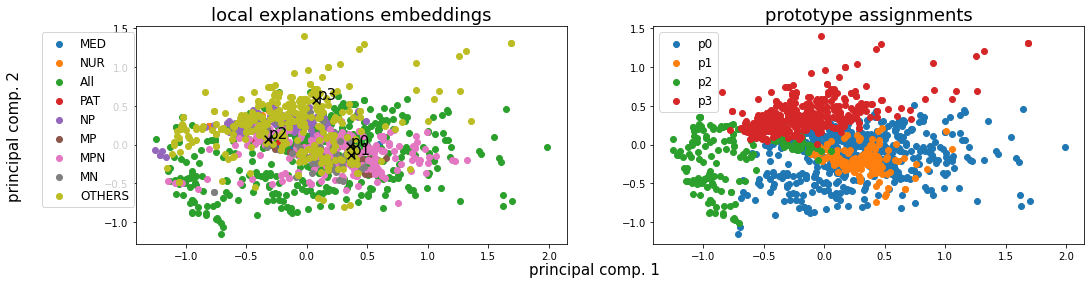

Alpha norms:
tensor([[0.1444, 1.0000, 0.1162, 0.5859],
        [0.1575, 1.0000, 0.2991, 0.7801]], grad_fn=<DivBackward0>)
Concept Purity: 0.416609 +- 0.094059
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([504, 177, 202, 367], dtype=int64))
Logic formulas:
For class 0:
0.708 (feature003)
For class 1:
0.7048 ((feature000) | (feature001)
Accuracy as classifier:  0.6256
LEN fidelity:  tensor(0.6256)


 80: Loss: 0.07779, LEN: 0.072927, AccxC: 0.67, AccO: 0.64, V. Acc: 0.65, V. Loss: 0.06746, V. LEN 0.06
 81: Loss: 0.07881, LEN: 0.075037, AccxC: 0.67, AccO: 0.61, V. Acc: 0.62, V. Loss: 0.06767, V. LEN 0.07
 82: Loss: 0.07597, LEN: 0.071303, AccxC: 0.70, AccO: 0.65, V. Acc: 0.70, V. Loss: 0.06513, V. LEN 0.06
 83: Loss: 0.07640, LEN: 0.072377, AccxC: 0.68, AccO: 0.64, V. Acc: 0.71, V. Loss: 0.06562, V. LEN 0.06
 84: Loss: 0.07624, LEN: 0.072239, AccxC: 0.67, AccO: 0.62, V. Acc: 0.57, V. Loss: 0.07035, V. LEN 0.07
 85: Loss: 0.07478, LEN: 0.070998, AccxC: 0.68, AccO: 0.63, 

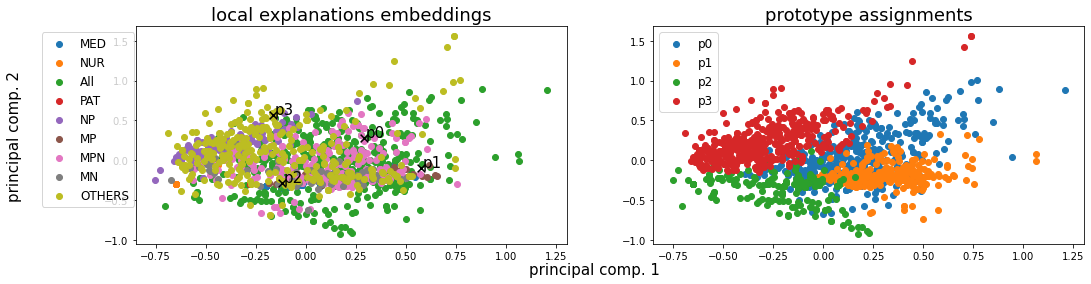

Alpha norms:
tensor([[0.0826, 1.0000, 0.0786, 0.4091],
        [0.1511, 1.0000, 0.2565, 0.8046]], grad_fn=<DivBackward0>)
Concept Purity: 0.405739 +- 0.101243
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([360, 287, 187, 416], dtype=int64))
Logic formulas:
For class 0:
0.752 (feature003)
For class 1:
0.752 (feature001) | (feature002) | ((feature000)
Accuracy as classifier:  0.752
LEN fidelity:  tensor(0.7520)


100: Loss: 0.07000, LEN: 0.067163, AccxC: 0.72, AccO: 0.72, V. Acc: 0.79, V. Loss: 0.06377, V. LEN 0.06
101: Loss: 0.06977, LEN: 0.067025, AccxC: 0.71, AccO: 0.71, V. Acc: 0.78, V. Loss: 0.05827, V. LEN 0.06
102: Loss: 0.06854, LEN: 0.065941, AccxC: 0.74, AccO: 0.74, V. Acc: 0.77, V. Loss: 0.06001, V. LEN 0.06
103: Loss: 0.06937, LEN: 0.066502, AccxC: 0.73, AccO: 0.73, V. Acc: 0.76, V. Loss: 0.05923, V. LEN 0.06
104: Loss: 0.06937, LEN: 0.066318, AccxC: 0.71, AccO: 0.71, V. Acc: 0.79, V. Loss: 0.05627, V. LEN 0.05
105: Loss: 0.06718, LEN: 0.064494, AccxC: 0.74,

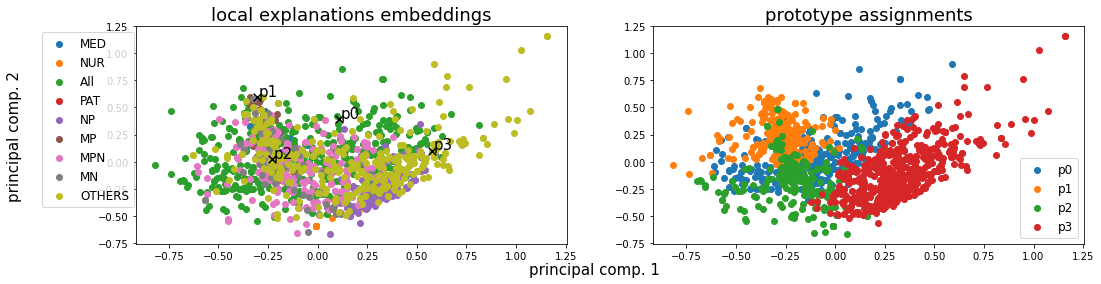

Alpha norms:
tensor([[0.0661, 1.0000, 0.0678, 0.3343],
        [0.1587, 1.0000, 0.2433, 0.7992]], grad_fn=<DivBackward0>)
Concept Purity: 0.404928 +- 0.133223
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([261, 277, 235, 477], dtype=int64))
Logic formulas:
For class 0:
0.8056 (feature003)
For class 1:
0.8056 (feature001) | (feature002) | ((feature000)
Accuracy as classifier:  0.8056
LEN fidelity:  tensor(0.8056)


120: Loss: 0.06148, LEN: 0.058829, AccxC: 0.78, AccO: 0.78, V. Acc: 0.81, V. Loss: 0.05351, V. LEN 0.05
121: Loss: 0.06081, LEN: 0.058472, AccxC: 0.77, AccO: 0.77, V. Acc: 0.79, V. Loss: 0.05541, V. LEN 0.05
122: Loss: 0.06134, LEN: 0.059063, AccxC: 0.77, AccO: 0.77, V. Acc: 0.79, V. Loss: 0.05261, V. LEN 0.05
123: Loss: 0.05876, LEN: 0.056721, AccxC: 0.79, AccO: 0.79, V. Acc: 0.79, V. Loss: 0.05756, V. LEN 0.06
124: Loss: 0.05880, LEN: 0.056934, AccxC: 0.78, AccO: 0.78, V. Acc: 0.79, V. Loss: 0.05129, V. LEN 0.05
125: Loss: 0.05966, LEN: 0.057434, AccxC: 0.

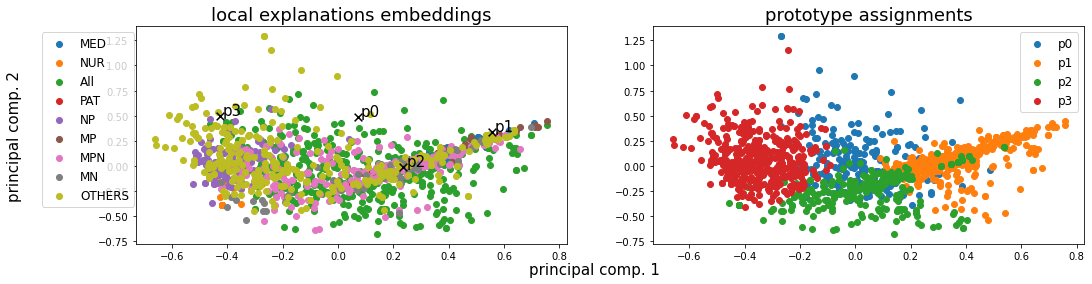

Alpha norms:
tensor([[0.0672, 1.0000, 0.0715, 0.3340],
        [0.2001, 1.0000, 0.2696, 0.9283]], grad_fn=<DivBackward0>)
Concept Purity: 0.439526 +- 0.128757
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([193, 365, 269, 423], dtype=int64))
Logic formulas:
For class 0:
0.8464 (feature003) | ((feature000)
For class 1:
0.8464 (feature001) | (feature002)
Accuracy as classifier:  0.8464
LEN fidelity:  tensor(0.8464)


140: Loss: 0.05908, LEN: 0.057005, AccxC: 0.80, AccO: 0.80, V. Acc: 0.88, V. Loss: 0.04603, V. LEN 0.04
141: Loss: 0.05726, LEN: 0.055179, AccxC: 0.81, AccO: 0.81, V. Acc: 0.87, V. Loss: 0.04273, V. LEN 0.04
142: Loss: 0.05587, LEN: 0.053959, AccxC: 0.82, AccO: 0.82, V. Acc: 0.86, V. Loss: 0.04637, V. LEN 0.04
143: Loss: 0.05661, LEN: 0.054462, AccxC: 0.82, AccO: 0.82, V. Acc: 0.87, V. Loss: 0.04572, V. LEN 0.04
144: Loss: 0.05417, LEN: 0.052195, AccxC: 0.82, AccO: 0.82, V. Acc: 0.88, V. Loss: 0.04415, V. LEN 0.04
145: Loss: 0.05584, LEN: 0.054054, AccxC: 0.

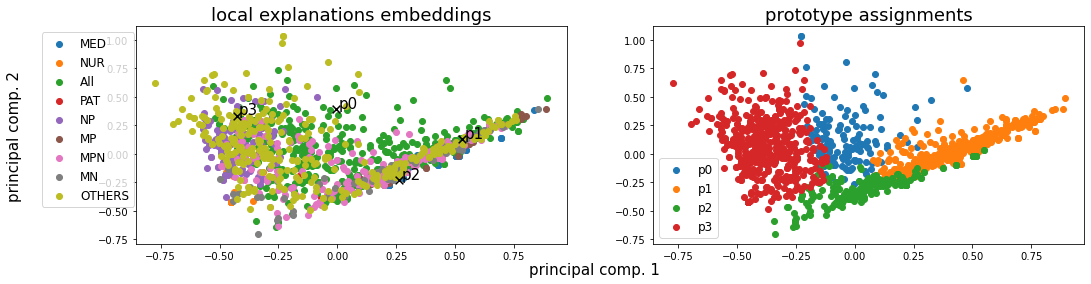

Alpha norms:
tensor([[0.0710, 1.0000, 0.0753, 0.3611],
        [0.1844, 0.9036, 0.2492, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.428452 +- 0.146934
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([141, 429, 201, 479], dtype=int64))
Logic formulas:
For class 0:
0.8816 (feature003) | ((feature000)
For class 1:
0.8816 (feature001) | (feature002)
Accuracy as classifier:  0.8816
LEN fidelity:  tensor(0.8816)


160: Loss: 0.04964, LEN: 0.048226, AccxC: 0.85, AccO: 0.85, V. Acc: 0.89, V. Loss: 0.03905, V. LEN 0.04
161: Loss: 0.04848, LEN: 0.046974, AccxC: 0.85, AccO: 0.85, V. Acc: 0.88, V. Loss: 0.04078, V. LEN 0.04
162: Loss: 0.04848, LEN: 0.046882, AccxC: 0.86, AccO: 0.86, V. Acc: 0.92, V. Loss: 0.03605, V. LEN 0.03
163: Loss: 0.04778, LEN: 0.046180, AccxC: 0.86, AccO: 0.86, V. Acc: 0.88, V. Loss: 0.04210, V. LEN 0.04
164: Loss: 0.04667, LEN: 0.045174, AccxC: 0.86, AccO: 0.86, V. Acc: 0.88, V. Loss: 0.04030, V. LEN 0.04
165: Loss: 0.04954, LEN: 0.047788, AccxC: 0.

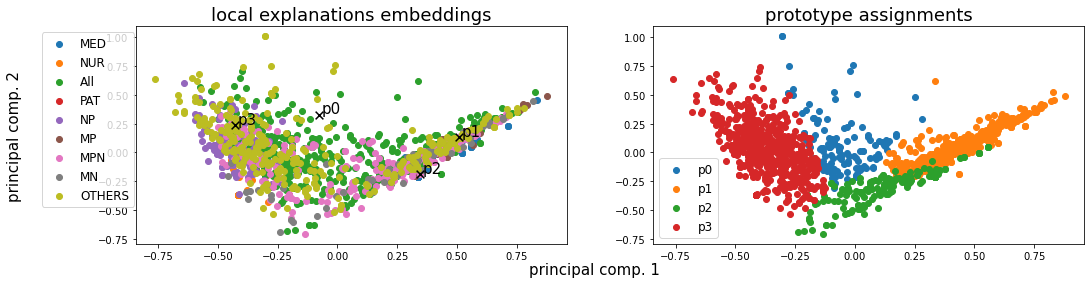

Alpha norms:
tensor([[0.0697, 1.0000, 0.0768, 0.3539],
        [0.1732, 0.8793, 0.2369, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.414427 +- 0.108099
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([128, 427, 164, 531], dtype=int64))
Logic formulas:
For class 0:
0.8776 (feature003) | ((feature000)
For class 1:
0.8776 (feature001) | (feature002)
Accuracy as classifier:  0.8776
LEN fidelity:  tensor(0.8776)


180: Loss: 0.04623, LEN: 0.044625, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.03971, V. LEN 0.04
181: Loss: 0.04543, LEN: 0.043942, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.04262, V. LEN 0.04
182: Loss: 0.04789, LEN: 0.046586, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04226, V. LEN 0.04
183: Loss: 0.04535, LEN: 0.043923, AccxC: 0.88, AccO: 0.88, V. Acc: 0.89, V. Loss: 0.04166, V. LEN 0.04
184: Loss: 0.04355, LEN: 0.042048, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.03647, V. LEN 0.04
185: Loss: 0.04591, LEN: 0.044499, AccxC: 0.

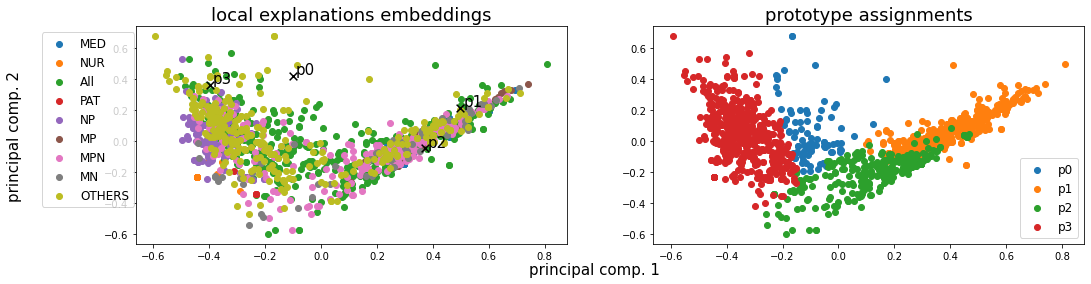

Alpha norms:
tensor([[0.0674, 1.0000, 0.0742, 0.3225],
        [0.1804, 0.9617, 0.2455, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.427899 +- 0.106653
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 87, 382, 267, 514], dtype=int64))
Logic formulas:
For class 0:
0.9032 (feature003) | ((feature000)
For class 1:
0.9032 (feature001) | (feature002)
Accuracy as classifier:  0.9032
LEN fidelity:  tensor(0.9032)


200: Loss: 0.04311, LEN: 0.041899, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.03998, V. LEN 0.04
201: Loss: 0.04461, LEN: 0.043278, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.03881, V. LEN 0.04
202: Loss: 0.04002, LEN: 0.038958, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03573, V. LEN 0.03
203: Loss: 0.04267, LEN: 0.041434, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03577, V. LEN 0.03
204: Loss: 0.04135, LEN: 0.040008, AccxC: 0.89, AccO: 0.89, V. Acc: 0.93, V. Loss: 0.03328, V. LEN 0.03
205: Loss: 0.04202, LEN: 0.040811, AccxC: 0.

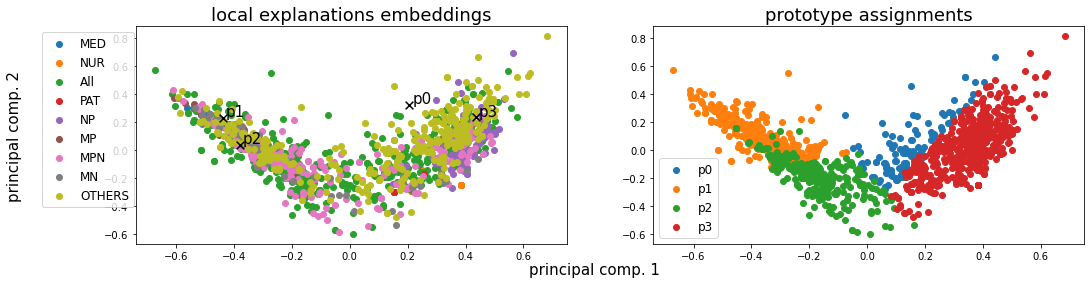

Alpha norms:
tensor([[0.0663, 1.0000, 0.0746, 0.3068],
        [0.1848, 0.9982, 0.2476, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.385603 +- 0.057437
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([114, 389, 247, 500], dtype=int64))
Logic formulas:
For class 0:
0.9152 (feature003) | ((feature000)
For class 1:
0.9152 (feature001) | (feature002)
Accuracy as classifier:  0.9152
LEN fidelity:  tensor(0.9152)


220: Loss: 0.04097, LEN: 0.039666, AccxC: 0.89, AccO: 0.89, V. Acc: 0.93, V. Loss: 0.03663, V. LEN 0.04
221: Loss: 0.04233, LEN: 0.041441, AccxC: 0.89, AccO: 0.89, V. Acc: 0.90, V. Loss: 0.03976, V. LEN 0.04
222: Loss: 0.03704, LEN: 0.036016, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03486, V. LEN 0.03
223: Loss: 0.03998, LEN: 0.038861, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03877, V. LEN 0.04
224: Loss: 0.04075, LEN: 0.039603, AccxC: 0.88, AccO: 0.88, V. Acc: 0.93, V. Loss: 0.03290, V. LEN 0.03
225: Loss: 0.03718, LEN: 0.036045, AccxC: 0.

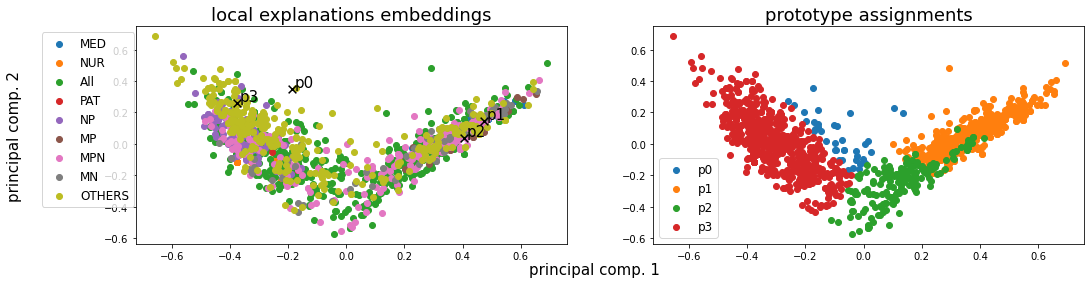

Alpha norms:
tensor([[0.0655, 1.0000, 0.0692, 0.2744],
        [0.1850, 1.0000, 0.2332, 0.8466]], grad_fn=<DivBackward0>)
Concept Purity: 0.426993 +- 0.101153
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 38, 431, 187, 594], dtype=int64))
Logic formulas:
For class 0:
0.9168 (feature003) | ((feature000)
For class 1:
0.9168 (feature001) | (feature002)
Accuracy as classifier:  0.9168
LEN fidelity:  tensor(0.9168)


240: Loss: 0.04003, LEN: 0.039075, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03847, V. LEN 0.04
241: Loss: 0.03828, LEN: 0.037290, AccxC: 0.91, AccO: 0.91, V. Acc: 0.93, V. Loss: 0.03438, V. LEN 0.03
242: Loss: 0.03830, LEN: 0.037425, AccxC: 0.91, AccO: 0.91, V. Acc: 0.93, V. Loss: 0.03573, V. LEN 0.03
243: Loss: 0.04005, LEN: 0.038946, AccxC: 0.90, AccO: 0.90, V. Acc: 0.93, V. Loss: 0.03364, V. LEN 0.03
244: Loss: 0.03604, LEN: 0.035326, AccxC: 0.91, AccO: 0.91, V. Acc: 0.92, V. Loss: 0.03837, V. LEN 0.04
245: Loss: 0.03772, LEN: 0.036652, AccxC: 0.

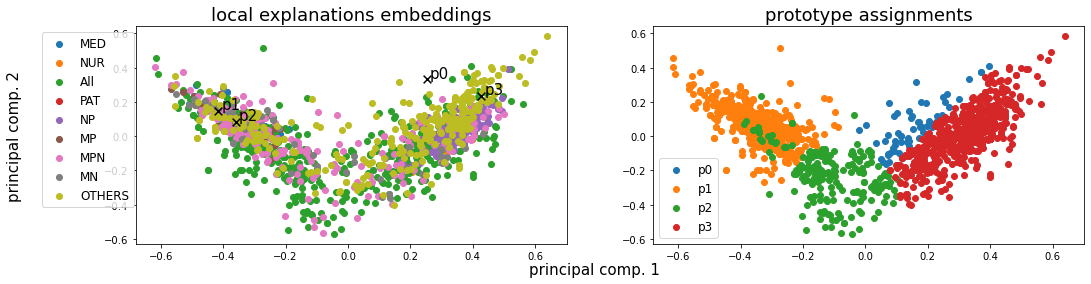

Alpha norms:
tensor([[0.0615, 1.0000, 0.0618, 0.2494],
        [0.1773, 1.0000, 0.2147, 0.7566]], grad_fn=<DivBackward0>)
Concept Purity: 0.431611 +- 0.109129
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 58, 448, 206, 538], dtype=int64))
Logic formulas:
For class 0:
0.9216 (feature003) | ((feature000)
For class 1:
0.9216 (feature001) | (feature002)
Accuracy as classifier:  0.9216
LEN fidelity:  tensor(0.9216)


260: Loss: 0.03854, LEN: 0.037648, AccxC: 0.90, AccO: 0.90, V. Acc: 0.93, V. Loss: 0.03502, V. LEN 0.03
261: Loss: 0.03766, LEN: 0.036820, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03739, V. LEN 0.04
262: Loss: 0.03851, LEN: 0.037595, AccxC: 0.90, AccO: 0.90, V. Acc: 0.93, V. Loss: 0.03273, V. LEN 0.03
263: Loss: 0.03556, LEN: 0.034740, AccxC: 0.91, AccO: 0.91, V. Acc: 0.93, V. Loss: 0.03311, V. LEN 0.03
264: Loss: 0.04058, LEN: 0.039785, AccxC: 0.90, AccO: 0.90, V. Acc: 0.93, V. Loss: 0.03532, V. LEN 0.03
265: Loss: 0.03626, LEN: 0.035387, AccxC: 0.

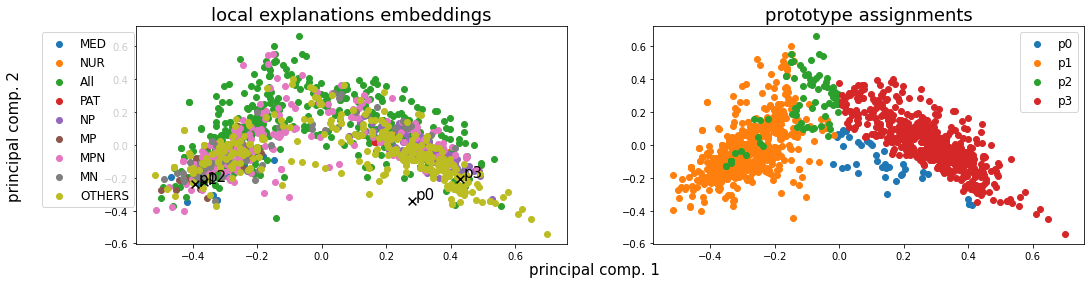

Alpha norms:
tensor([[0.0612, 1.0000, 0.0586, 0.2454],
        [0.1810, 1.0000, 0.2099, 0.7384]], grad_fn=<DivBackward0>)
Concept Purity: 0.407615 +- 0.065772
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 38, 550,  84, 578], dtype=int64))
Logic formulas:
For class 0:
0.9232 (feature003) | (feature000)
For class 1:
0.9232 (feature001) | (feature002)
Accuracy as classifier:  0.9232
LEN fidelity:  tensor(0.9232)


280: Loss: 0.03505, LEN: 0.034204, AccxC: 0.92, AccO: 0.92, V. Acc: 0.93, V. Loss: 0.03702, V. LEN 0.04
281: Loss: 0.03816, LEN: 0.037446, AccxC: 0.92, AccO: 0.92, V. Acc: 0.93, V. Loss: 0.03975, V. LEN 0.04
282: Loss: 0.04394, LEN: 0.043263, AccxC: 0.90, AccO: 0.90, V. Acc: 0.93, V. Loss: 0.03942, V. LEN 0.04
283: Loss: 0.03831, LEN: 0.037491, AccxC: 0.92, AccO: 0.92, V. Acc: 0.93, V. Loss: 0.03994, V. LEN 0.04
284: Loss: 0.03968, LEN: 0.038962, AccxC: 0.91, AccO: 0.91, V. Acc: 0.93, V. Loss: 0.03889, V. LEN 0.04
285: Loss: 0.04173, LEN: 0.040791, AccxC: 0.9

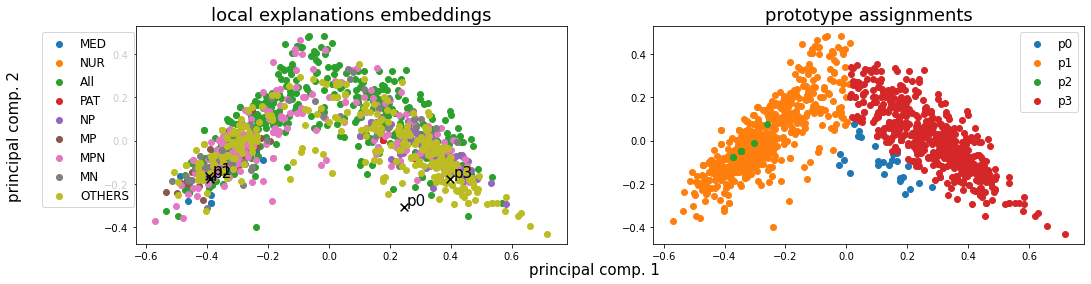

Alpha norms:
tensor([[0.0839, 1.0000, 0.0842, 0.3442],
        [0.2346, 0.9204, 0.2722, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.446888 +- 0.114103
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 26, 613,  11, 600], dtype=int64))
Logic formulas:
For class 0:
0.9296 (feature003) | ((feature000)
For class 1:
0.9296 (feature001) | (feature002)
Accuracy as classifier:  0.9296
LEN fidelity:  tensor(0.9296)


300: Loss: 0.03946, LEN: 0.038863, AccxC: 0.92, AccO: 0.92, V. Acc: 0.92, V. Loss: 0.04030, V. LEN 0.04
301: Loss: 0.04144, LEN: 0.040857, AccxC: 0.91, AccO: 0.91, V. Acc: 0.93, V. Loss: 0.03773, V. LEN 0.04
302: Loss: 0.03979, LEN: 0.039140, AccxC: 0.91, AccO: 0.91, V. Acc: 0.93, V. Loss: 0.03784, V. LEN 0.04
303: Loss: 0.03992, LEN: 0.039105, AccxC: 0.91, AccO: 0.91, V. Acc: 0.93, V. Loss: 0.03777, V. LEN 0.04
304: Loss: 0.04220, LEN: 0.041491, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.04013, V. LEN 0.04
305: Loss: 0.03735, LEN: 0.036738, AccxC: 0.

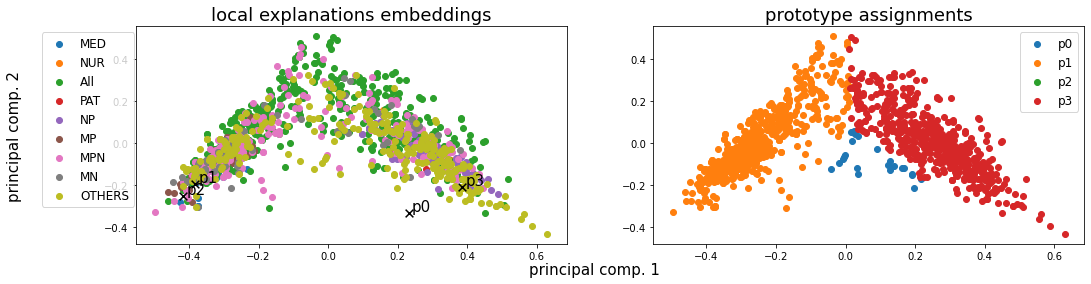

Alpha norms:
tensor([[0.0858, 1.0000, 0.0911, 0.3536],
        [0.2371, 0.9009, 0.2816, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.425068 +- 0.101752
Concept distribution:  (array([0, 1, 3], dtype=int64), array([ 23, 621, 606], dtype=int64))
Logic formulas:
For class 0:
0.9288 (feature003) | ((feature000)
For class 1:
0.9288 (feature001)
Accuracy as classifier:  0.9288
LEN fidelity:  tensor(0.9288)


320: Loss: 0.03982, LEN: 0.039147, AccxC: 0.91, AccO: 0.91, V. Acc: 0.92, V. Loss: 0.04062, V. LEN 0.04
321: Loss: 0.03985, LEN: 0.039236, AccxC: 0.92, AccO: 0.92, V. Acc: 0.91, V. Loss: 0.04353, V. LEN 0.04
322: Loss: 0.04111, LEN: 0.040498, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.04033, V. LEN 0.04
323: Loss: 0.04001, LEN: 0.039455, AccxC: 0.91, AccO: 0.91, V. Acc: 0.92, V. Loss: 0.04063, V. LEN 0.04
324: Loss: 0.03978, LEN: 0.039127, AccxC: 0.92, AccO: 0.92, V. Acc: 0.92, V. Loss: 0.04055, V. LEN 0.04
325: Loss: 0.04104, LEN: 0.040347, AccxC: 0.91, AccO: 0.91, V. Acc:

In [ ]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)

torch.manual_seed(42)
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 4,
    "dim_prototypes": 10,
    "num_le_features": 5,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": True,
    "num_epochs": 500
}

len_model    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"]).to(device)
expl3         = models.GlobalExplainer(len_model, 
                               le_model, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=priori_etn_classes_names,
                               dataset_name="ETN").to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
suffix = "no attn" if hyper["remove_attention"] else ""
expl3.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb=f"MUTAG {hyper['num_prototypes']}prots {prefix} {suffix}")

(array([0., 1., 2., 3., 4., 5., 6.], dtype=float32), array([266, 125,  24,  47,  63,  41, 143], dtype=int64))
[0.868509   0.08787009]


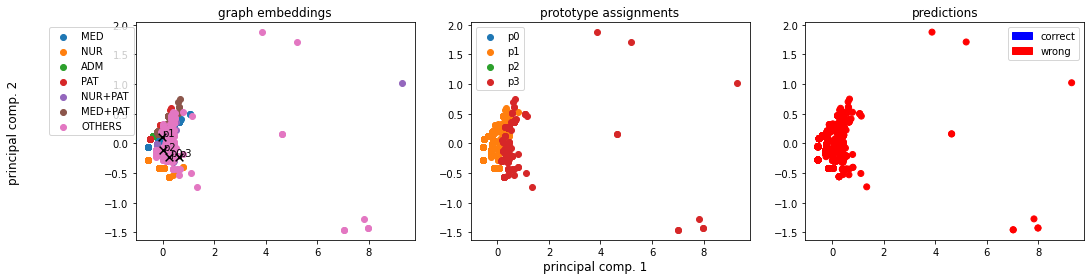

Alpha norms:
tensor([[1.0000, 0.8459, 0.8427, 0.9224],
        [0.8005, 0.7799, 1.0000, 0.8565]], grad_fn=<DivBackward0>)
Concept Purity: 0.382089 +- 0.002527
Concept distribution:  (array([1, 3], dtype=int64), array([572, 137], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0

  1: Loss: 0.32154, LEN: 0.097604, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.31756, V. LEN 0.10
  2: Loss: 0.30562, LEN: 0.097152, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.29682, V. LEN 0.10
  3: Loss: 0.28392, LEN: 0.096678, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.28418, V. LEN 0.10
  4: Loss: 0.26569, LEN: 0.096203, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.26648, V. LEN 0.10
  5: Loss: 0.23506, LEN: 0.095783, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.22125, V. LEN 0.10
  6: Loss: 0.19838, LEN: 0.095347, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.18057, V. LEN 0.10
  7: Loss: 0.17198, LEN: 0.094815, AccxC: 0.58,

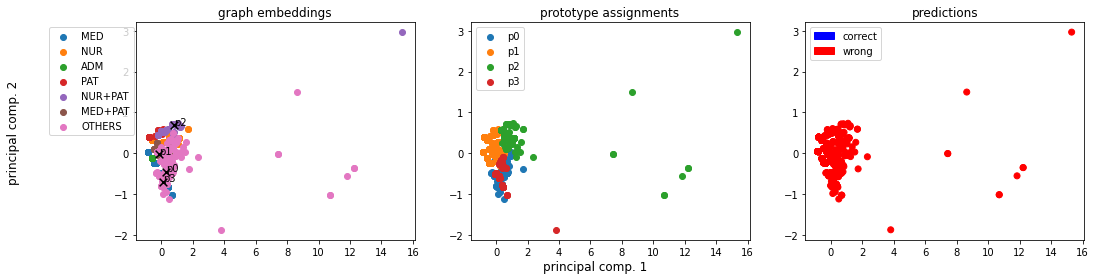

Alpha norms:
tensor([[0.9788, 0.7350, 0.7176, 1.0000],
        [0.8274, 0.8097, 0.9891, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.639124 +- 0.264107
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 68, 430,  96, 115], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0

 20: Loss: 0.10109, LEN: 0.089560, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.10112, V. LEN 0.09
 21: Loss: 0.09946, LEN: 0.089240, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09919, V. LEN 0.09
 22: Loss: 0.09839, LEN: 0.088821, AccxC: 0.65, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09856, V. LEN 0.09
 23: Loss: 0.09874, LEN: 0.088493, AccxC: 0.68, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09773, V. LEN 0.09
 24: Loss: 0.09711, LEN: 0.088245, AccxC: 0.69, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09691, V. LEN 0.09
 25: Loss: 0.09679, LEN: 0.088000, AccxC: 0.71, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09629, V. LEN 0.09
 26: Loss: 0.09666, LEN: 0.0876

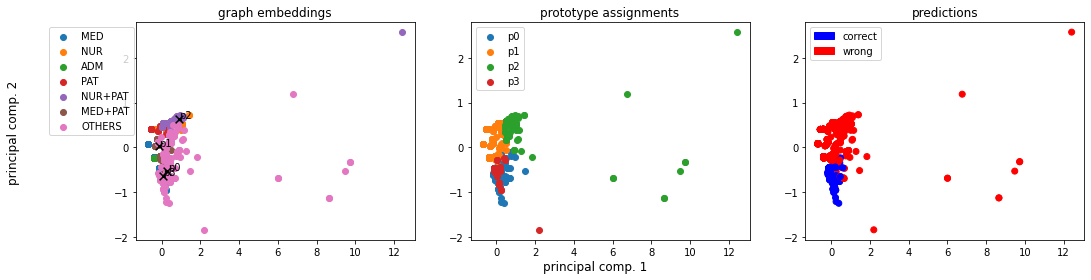

Alpha norms:
tensor([[0.7753, 0.6474, 0.7708, 1.0000],
        [0.5234, 0.4944, 0.9218, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.659419 +- 0.277499
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 66, 443,  96, 104], dtype=int64))
Logic formulas:
For class 0:
0.5613540197461213 ((feature001) | (feature002)
For class 1:
0.0 ()
Accuracy as classifier:  0.0

 40: Loss: 0.08952, LEN: 0.083355, AccxC: 0.69, AccO: 0.20, V. Acc: 0.23, V. Loss: 0.08996, V. LEN 0.08
 41: Loss: 0.08991, LEN: 0.083187, AccxC: 0.68, AccO: 0.21, V. Acc: 0.23, V. Loss: 0.08820, V. LEN 0.08
 42: Loss: 0.08905, LEN: 0.082725, AccxC: 0.70, AccO: 0.52, V. Acc: 0.71, V. Loss: 0.08732, V. LEN 0.08
 43: Loss: 0.08792, LEN: 0.082477, AccxC: 0.70, AccO: 0.70, V. Acc: 0.71, V. Loss: 0.08750, V. LEN 0.08
 44: Loss: 0.08716, LEN: 0.082170, AccxC: 0.69, AccO: 0.69, V. Acc: 0.67, V. Loss: 0.08896, V. LEN 0.08
 45: Loss: 0.08831, LEN: 0.082108, AccxC: 0.69, AccO: 0.69, V. Acc: 0.67, V. Loss: 0.08946, V.

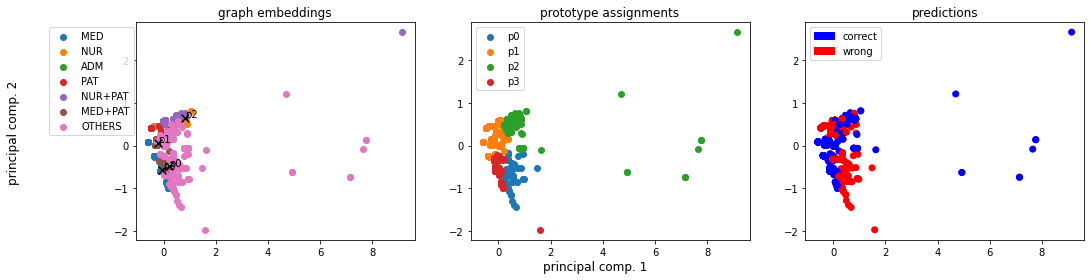

Alpha norms:
tensor([[0.3988, 0.4638, 0.5561, 1.0000],
        [0.2753, 0.2562, 0.8613, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.574521 +- 0.173296
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 86, 400, 106, 117], dtype=int64))
Logic formulas:
For class 0:
0.692524682651622 (feature002)
For class 1:
0.7009873060648801 ((feature001) | (feature003)
Accuracy as classifier:  0.6361

 60: Loss: 0.08119, LEN: 0.077728, AccxC: 0.70, AccO: 0.64, V. Acc: 0.56, V. Loss: 0.08285, V. LEN 0.08
 61: Loss: 0.08133, LEN: 0.077682, AccxC: 0.70, AccO: 0.64, V. Acc: 0.56, V. Loss: 0.08232, V. LEN 0.08
 62: Loss: 0.08109, LEN: 0.077190, AccxC: 0.69, AccO: 0.64, V. Acc: 0.56, V. Loss: 0.08189, V. LEN 0.08
 63: Loss: 0.08091, LEN: 0.076263, AccxC: 0.70, AccO: 0.65, V. Acc: 0.59, V. Loss: 0.08015, V. LEN 0.08
 64: Loss: 0.08037, LEN: 0.077141, AccxC: 0.69, AccO: 0.64, V. Acc: 0.56, V. Loss: 0.08169, V. LEN 0.08
 65: Loss: 0.07903, LEN: 0.076209, AccxC: 0.70, AccO: 0.65, V. Acc:

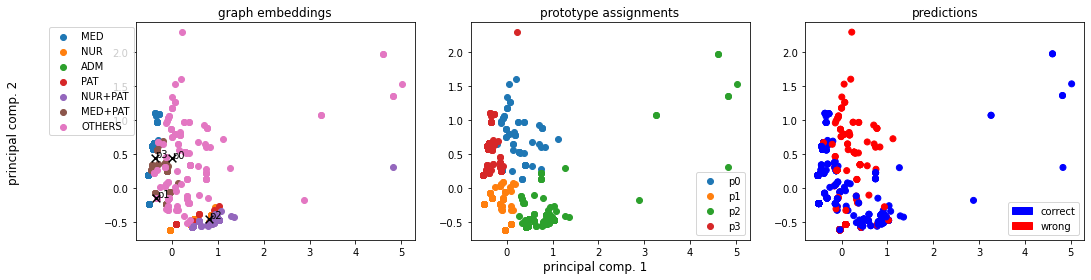

Alpha norms:
tensor([[0.2067, 0.2751, 0.5057, 1.0000],
        [0.1718, 0.2034, 1.0000, 0.9153]], grad_fn=<DivBackward0>)
Concept Purity: 0.586798 +- 0.187960
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 86, 281, 140, 202], dtype=int64))
Logic formulas:
For class 0:
0.7320169252468265 (feature002)
For class 1:
0.7404795486600846 (feature001) | (feature003)
Accuracy as classifier:  0.6756

 80: Loss: 0.07055, LEN: 0.068889, AccxC: 0.76, AccO: 0.71, V. Acc: 0.65, V. Loss: 0.06982, V. LEN 0.07
 81: Loss: 0.07148, LEN: 0.069519, AccxC: 0.74, AccO: 0.69, V. Acc: 0.65, V. Loss: 0.06959, V. LEN 0.07
 82: Loss: 0.07094, LEN: 0.067741, AccxC: 0.76, AccO: 0.71, V. Acc: 0.65, V. Loss: 0.06867, V. LEN 0.07
 83: Loss: 0.06841, LEN: 0.065776, AccxC: 0.78, AccO: 0.73, V. Acc: 0.65, V. Loss: 0.06792, V. LEN 0.07
 84: Loss: 0.06710, LEN: 0.064878, AccxC: 0.79, AccO: 0.73, V. Acc: 0.68, V. Loss: 0.06476, V. LEN 0.06
 85: Loss: 0.06495, LEN: 0.063188, AccxC: 0.80, AccO: 0.74, V. Acc:

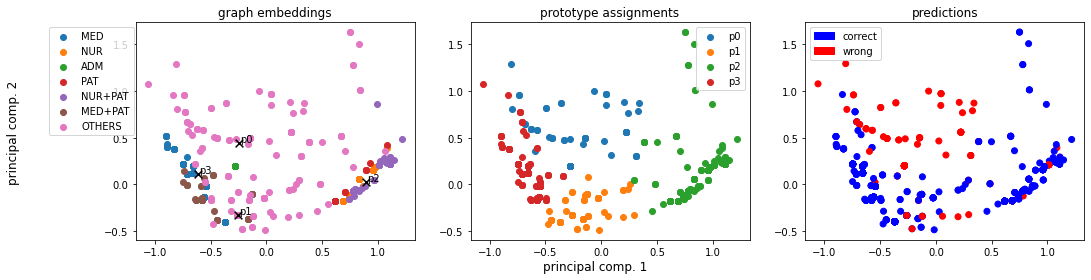

Alpha norms:
tensor([[0.1842, 0.2424, 0.6470, 1.0000],
        [0.1071, 0.2397, 1.0000, 0.8435]], grad_fn=<DivBackward0>)
Concept Purity: 0.637066 +- 0.106406
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 73, 162, 261, 213], dtype=int64))
Logic formulas:
For class 0:
0.849083215796897 (feature002)
For class 1:
0.8702397743300423 (feature001) | (feature003)
Accuracy as classifier:  0.8082

100: Loss: 0.05385, LEN: 0.052198, AccxC: 0.84, AccO: 0.79, V. Acc: 0.76, V. Loss: 0.05100, V. LEN 0.05
101: Loss: 0.05485, LEN: 0.052906, AccxC: 0.83, AccO: 0.78, V. Acc: 0.76, V. Loss: 0.05048, V. LEN 0.05
102: Loss: 0.05626, LEN: 0.054971, AccxC: 0.82, AccO: 0.78, V. Acc: 0.76, V. Loss: 0.05040, V. LEN 0.05
103: Loss: 0.05313, LEN: 0.051745, AccxC: 0.84, AccO: 0.80, V. Acc: 0.76, V. Loss: 0.04981, V. LEN 0.05
104: Loss: 0.05270, LEN: 0.051571, AccxC: 0.85, AccO: 0.79, V. Acc: 0.76, V. Loss: 0.04962, V. LEN 0.05
105: Loss: 0.05383, LEN: 0.052472, AccxC: 0.86, AccO: 0.79, V. Acc: 

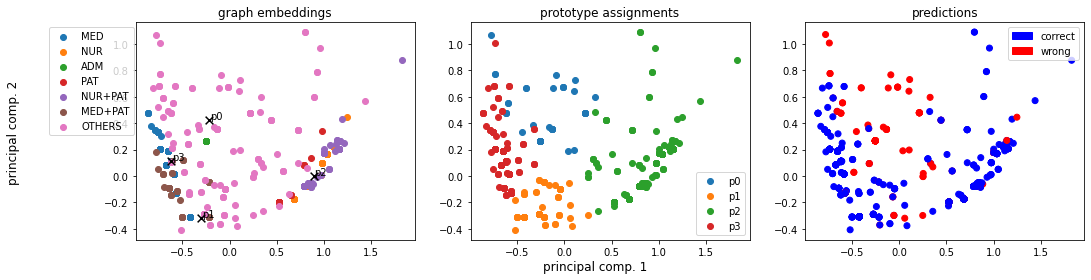

Alpha norms:
tensor([[0.2280, 0.2303, 0.5880, 1.0000],
        [0.1142, 0.2697, 1.0000, 0.8071]], grad_fn=<DivBackward0>)
Concept Purity: 0.606625 +- 0.102519
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 58, 161, 270, 220], dtype=int64))
Logic formulas:
For class 0:
0.8504936530324401 (feature002)
For class 1:
0.8758815232722144 (feature001) | (feature003)
Accuracy as classifier:  0.8223

120: Loss: 0.05256, LEN: 0.051288, AccxC: 0.86, AccO: 0.80, V. Acc: 0.80, V. Loss: 0.04592, V. LEN 0.04
121: Loss: 0.05155, LEN: 0.050692, AccxC: 0.87, AccO: 0.81, V. Acc: 0.80, V. Loss: 0.04643, V. LEN 0.04
122: Loss: 0.05073, LEN: 0.049244, AccxC: 0.86, AccO: 0.81, V. Acc: 0.80, V. Loss: 0.04606, V. LEN 0.04
123: Loss: 0.05124, LEN: 0.050347, AccxC: 0.87, AccO: 0.81, V. Acc: 0.79, V. Loss: 0.04652, V. LEN 0.05
124: Loss: 0.04965, LEN: 0.048718, AccxC: 0.86, AccO: 0.81, V. Acc: 0.80, V. Loss: 0.04613, V. LEN 0.04
125: Loss: 0.05256, LEN: 0.051645, AccxC: 0.86, AccO: 0.80, V. Acc:

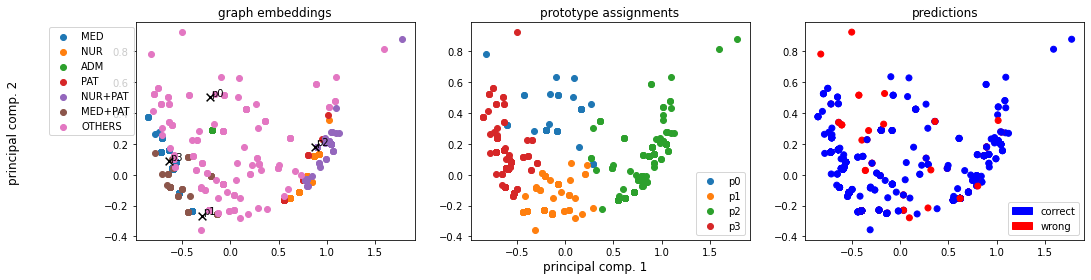

Alpha norms:
tensor([[0.2910, 0.2068, 0.5255, 1.0000],
        [0.1305, 0.2816, 1.0000, 0.8717]], grad_fn=<DivBackward0>)
Concept Purity: 0.595644 +- 0.093778
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 55, 165, 264, 225], dtype=int64))
Logic formulas:
For class 0:
0.8857545839210155 (feature002) | (feature000)
For class 1:
0.8857545839210155 (feature001) | (feature003)
Accuracy as classifier:  0.8858

140: Loss: 0.05072, LEN: 0.049717, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04551, V. LEN 0.04
141: Loss: 0.05155, LEN: 0.050230, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04553, V. LEN 0.04
142: Loss: 0.05054, LEN: 0.049392, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.04488, V. LEN 0.04
143: Loss: 0.05477, LEN: 0.053721, AccxC: 0.85, AccO: 0.85, V. Acc: 0.88, V. Loss: 0.04530, V. LEN 0.04
144: Loss: 0.04979, LEN: 0.048733, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04510, V. LEN 0.04
145: Loss: 0.04845, LEN: 0.047381, AccxC: 0.88, AccO

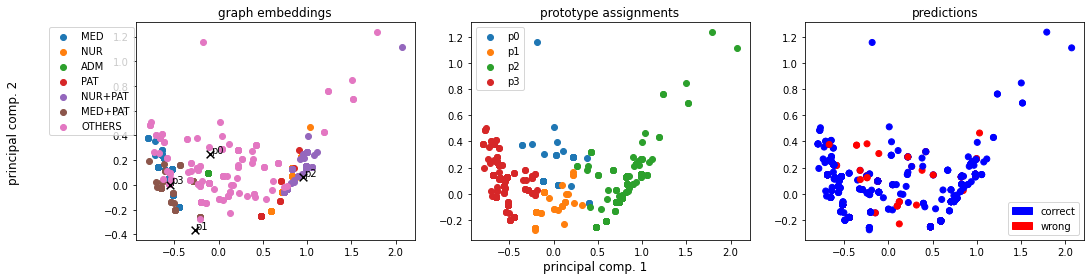

Alpha norms:
tensor([[0.4151, 0.1798, 0.4595, 1.0000],
        [0.1532, 0.2856, 0.9951, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.662315 +- 0.168122
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 51,  44, 264, 350], dtype=int64))
Logic formulas:
For class 0:
0.8942172073342737 (feature002) | (feature000)
For class 1:
0.8942172073342737 (feature003) | (feature001)
Accuracy as classifier:  0.8942

160: Loss: 0.04962, LEN: 0.048278, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.04018, V. LEN 0.04
161: Loss: 0.04986, LEN: 0.048780, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.03992, V. LEN 0.04
162: Loss: 0.05011, LEN: 0.048630, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.03981, V. LEN 0.04
163: Loss: 0.04898, LEN: 0.048056, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.03990, V. LEN 0.04
164: Loss: 0.04828, LEN: 0.047253, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.04015, V. LEN 0.04
165: Loss: 0.04754, LEN: 0.046553, AccxC: 0.88, AccO

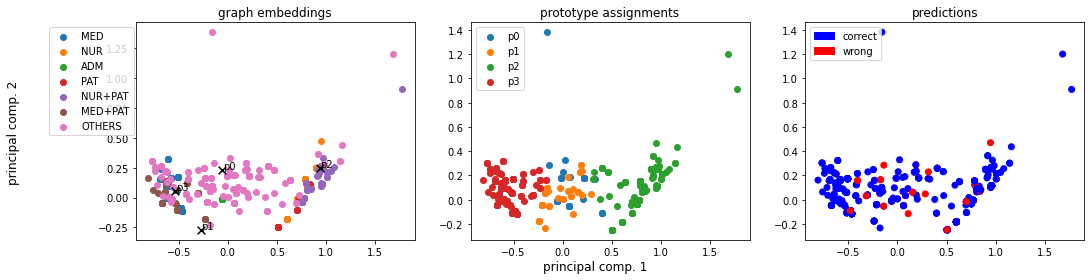

Alpha norms:
tensor([[0.4905, 0.1613, 0.4198, 1.0000],
        [0.1618, 0.2557, 0.9130, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.659819 +- 0.178250
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 48,  50, 262, 349], dtype=int64))
Logic formulas:
For class 0:
0.8984485190409027 (feature002) | (feature000)
For class 1:
0.8984485190409027 (feature003) | (feature001)
Accuracy as classifier:  0.8984

180: Loss: 0.04877, LEN: 0.047789, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.04065, V. LEN 0.04
181: Loss: 0.04817, LEN: 0.047046, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.04053, V. LEN 0.04
182: Loss: 0.04849, LEN: 0.047562, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.03975, V. LEN 0.04
183: Loss: 0.04480, LEN: 0.043826, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03954, V. LEN 0.04
184: Loss: 0.04656, LEN: 0.044852, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03915, V. LEN 0.04
185: Loss: 0.04778, LEN: 0.046664, AccxC: 0.88, AccO

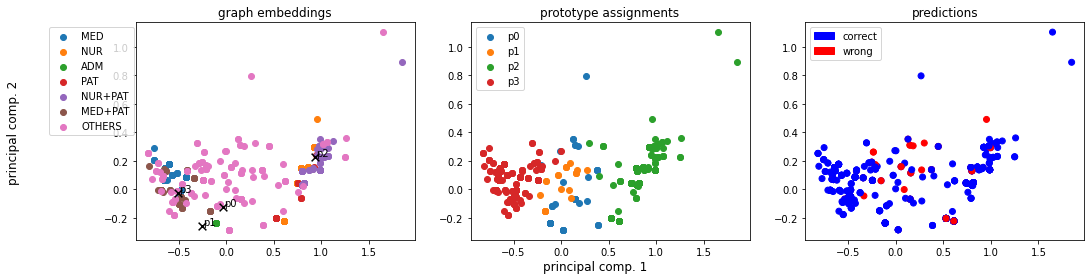

Alpha norms:
tensor([[0.4791, 0.1531, 0.4006, 1.0000],
        [0.1622, 0.2571, 0.8911, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.640092 +- 0.111515
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 58,  22, 257, 372], dtype=int64))
Logic formulas:
For class 0:
0.8942172073342737 (feature002) | (feature000)
For class 1:
0.8942172073342737 (feature003) | (feature001)
Accuracy as classifier:  0.8942

200: Loss: 0.04618, LEN: 0.044931, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04155, V. LEN 0.04
201: Loss: 0.04727, LEN: 0.045984, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04151, V. LEN 0.04
202: Loss: 0.04732, LEN: 0.046345, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04170, V. LEN 0.04
203: Loss: 0.04829, LEN: 0.046988, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04186, V. LEN 0.04
204: Loss: 0.04798, LEN: 0.046812, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03997, V. LEN 0.04
205: Loss: 0.04626, LEN: 0.044860, AccxC: 0.89, AccO

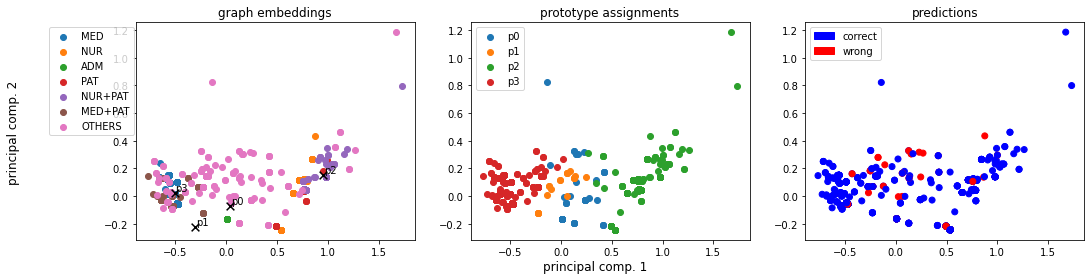

Alpha norms:
tensor([[0.4622, 0.1451, 0.3876, 1.0000],
        [0.1579, 0.2327, 0.8487, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.639140 +- 0.107562
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 59,  21, 257, 372], dtype=int64))
Logic formulas:
For class 0:
0.8928067700987306 (feature002) | (feature000)
For class 1:
0.8928067700987306 (feature003) | (feature001)
Accuracy as classifier:  0.8928

220: Loss: 0.04760, LEN: 0.046595, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04057, V. LEN 0.04
221: Loss: 0.04900, LEN: 0.048258, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04079, V. LEN 0.04
222: Loss: 0.04654, LEN: 0.045634, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04125, V. LEN 0.04
223: Loss: 0.04528, LEN: 0.044281, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04116, V. LEN 0.04
224: Loss: 0.04619, LEN: 0.045287, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04098, V. LEN 0.04
225: Loss: 0.04794, LEN: 0.046735, AccxC: 0.89, AccO

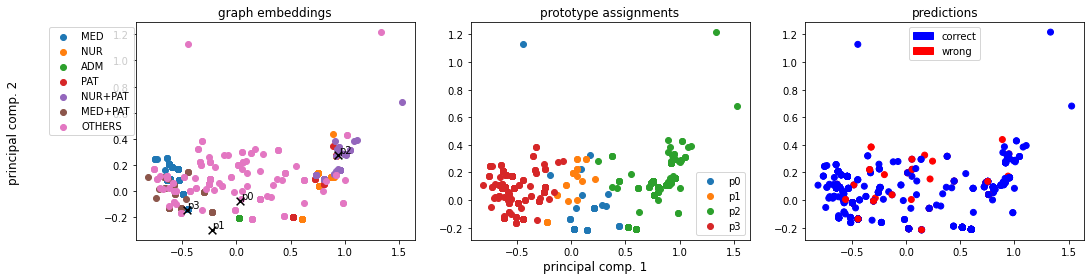

Alpha norms:
tensor([[0.4516, 0.1447, 0.3917, 1.0000],
        [0.1593, 0.2422, 0.8835, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.625456 +- 0.129976
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 50,  24, 261, 374], dtype=int64))
Logic formulas:
For class 0:
0.8970380818053597 (feature002) | (feature000)
For class 1:
0.8970380818053597 (feature003) | (feature001)
Accuracy as classifier:  0.897

240: Loss: 0.04704, LEN: 0.045991, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04165, V. LEN 0.04
241: Loss: 0.04641, LEN: 0.045643, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04165, V. LEN 0.04
242: Loss: 0.04671, LEN: 0.045252, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03915, V. LEN 0.04
243: Loss: 0.04695, LEN: 0.045594, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04082, V. LEN 0.04
244: Loss: 0.04721, LEN: 0.046226, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04081, V. LEN 0.04
245: Loss: 0.04777, LEN: 0.046899, AccxC: 0.88, AccO:

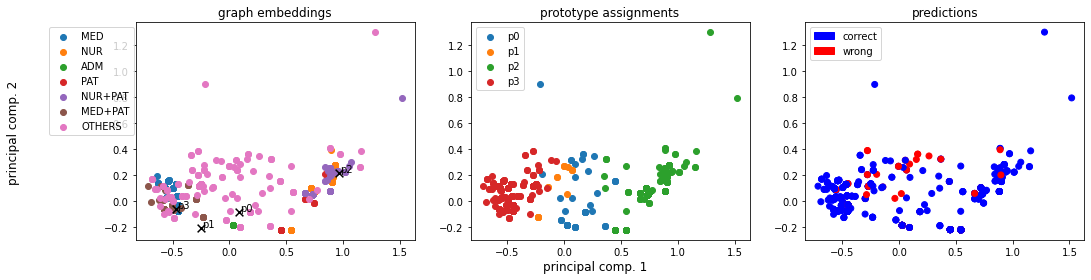

Alpha norms:
tensor([[0.4495, 0.1421, 0.3861, 1.0000],
        [0.1602, 0.2423, 0.8707, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.629574 +- 0.090460
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 62,  17, 256, 374], dtype=int64))
Logic formulas:
For class 0:
0.8928067700987306 (feature002) | (feature000)
For class 1:
0.8928067700987306 (feature003) | (feature001)
Accuracy as classifier:  0.8928

260: Loss: 0.04764, LEN: 0.046616, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04023, V. LEN 0.04
261: Loss: 0.04613, LEN: 0.045142, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03796, V. LEN 0.04
262: Loss: 0.04767, LEN: 0.046942, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.04095, V. LEN 0.04
263: Loss: 0.04430, LEN: 0.043388, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04090, V. LEN 0.04
264: Loss: 0.04536, LEN: 0.044371, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04082, V. LEN 0.04
265: Loss: 0.04748, LEN: 0.046688, AccxC: 0.87, AccO

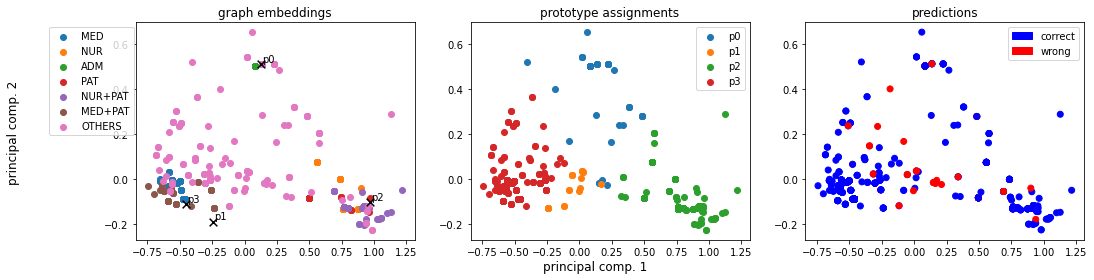

Alpha norms:
tensor([[0.4474, 0.1404, 0.3836, 1.0000],
        [0.1605, 0.2281, 0.8756, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.636906 +- 0.107015
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 58,  21, 256, 374], dtype=int64))
Logic formulas:
For class 0:
0.8928067700987306 (feature002) | (feature000)
For class 1:
0.8928067700987306 (feature003) | (feature001)
Accuracy as classifier:  0.8928

280: Loss: 0.04682, LEN: 0.045789, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03957, V. LEN 0.04
281: Loss: 0.04333, LEN: 0.042113, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03949, V. LEN 0.04
282: Loss: 0.04540, LEN: 0.044576, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.03980, V. LEN 0.04
283: Loss: 0.04701, LEN: 0.046150, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.03994, V. LEN 0.04
284: Loss: 0.04563, LEN: 0.044934, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03960, V. LEN 0.04
285: Loss: 0.04641, LEN: 0.044873, AccxC: 0.88, AccO

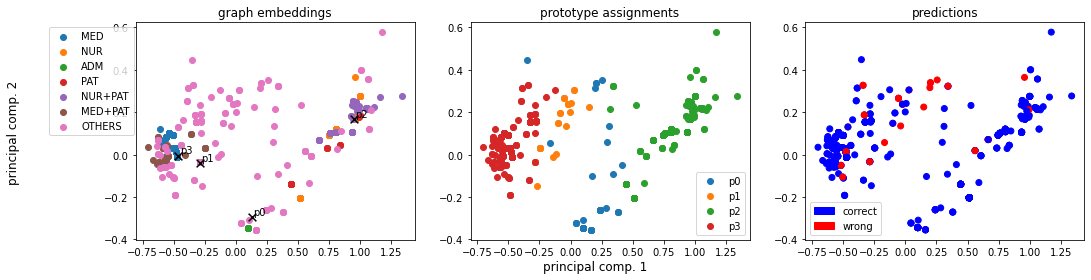

Alpha norms:
tensor([[0.4389, 0.1381, 0.3882, 1.0000],
        [0.1597, 0.2301, 0.9058, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.604537 +- 0.092585
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 54,  29, 259, 367], dtype=int64))
Logic formulas:
For class 0:
0.8942172073342737 (feature002) | (feature000)
For class 1:
0.8942172073342737 (feature003) | (feature001)
Accuracy as classifier:  0.8942

300: Loss: 0.04563, LEN: 0.044674, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03933, V. LEN 0.04
301: Loss: 0.04721, LEN: 0.046369, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.03925, V. LEN 0.04
302: Loss: 0.04449, LEN: 0.043679, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03938, V. LEN 0.04
303: Loss: 0.04626, LEN: 0.045428, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03915, V. LEN 0.04
304: Loss: 0.04479, LEN: 0.044074, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04010, V. LEN 0.04
305: Loss: 0.04627, LEN: 0.045562, AccxC: 0.88, AccO

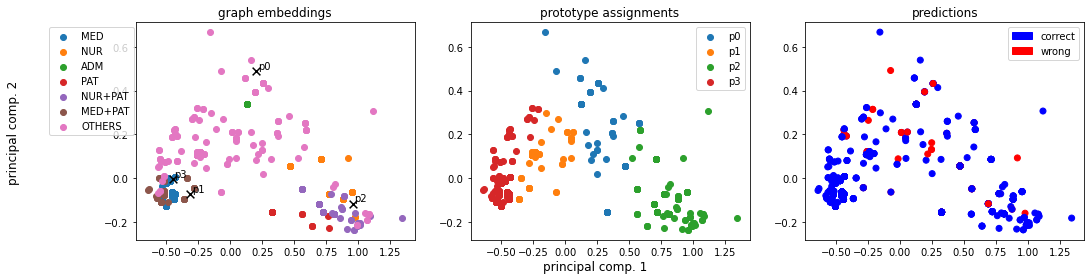

Alpha norms:
tensor([[0.4531, 0.1359, 0.3817, 1.0000],
        [0.1622, 0.2284, 0.8815, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.630657 +- 0.152750
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([188,  58, 126, 337], dtype=int64))
Logic formulas:
For class 0:
0.8956276445698167 (feature000) | (feature002)
For class 1:
0.8956276445698167 (feature003) | (feature001)
Accuracy as classifier:  0.8956

320: Loss: 0.04489, LEN: 0.043785, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03536, V. LEN 0.03
321: Loss: 0.04411, LEN: 0.043392, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03526, V. LEN 0.03
322: Loss: 0.04589, LEN: 0.045188, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.03510, V. LEN 0.03
323: Loss: 0.04344, LEN: 0.042560, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03561, V. LEN 0.03
324: Loss: 0.04324, LEN: 0.042354, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03567, V. LEN 0.03
325: Loss: 0.04363, LEN: 0.042912, AccxC: 0.89, AccO

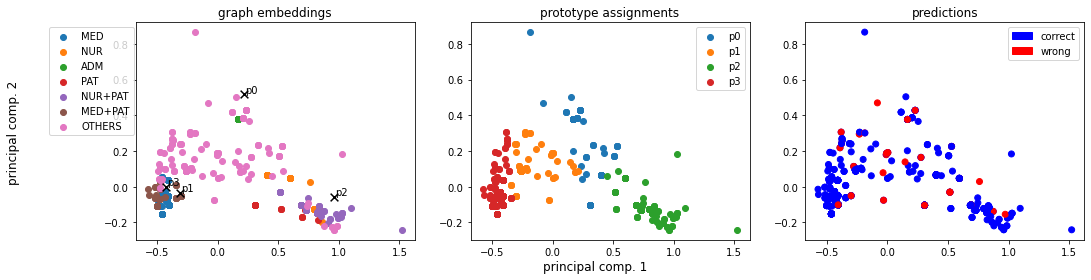

Alpha norms:
tensor([[0.4516, 0.1320, 0.3743, 1.0000],
        [0.1590, 0.2338, 0.8731, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.664961 +- 0.180241
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([187,  68, 122, 332], dtype=int64))
Logic formulas:
For class 0:
0.8998589562764457 (feature000) | (feature002)
For class 1:
0.8998589562764457 (feature003) | (feature001)
Accuracy as classifier:  0.8999

340: Loss: 0.04127, LEN: 0.040575, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03515, V. LEN 0.03
341: Loss: 0.04289, LEN: 0.042236, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03483, V. LEN 0.03
342: Loss: 0.04537, LEN: 0.044723, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03436, V. LEN 0.03
343: Loss: 0.04463, LEN: 0.043963, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03436, V. LEN 0.03
344: Loss: 0.04460, LEN: 0.043886, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03436, V. LEN 0.03
345: Loss: 0.04405, LEN: 0.043511, AccxC: 0.89, AccO

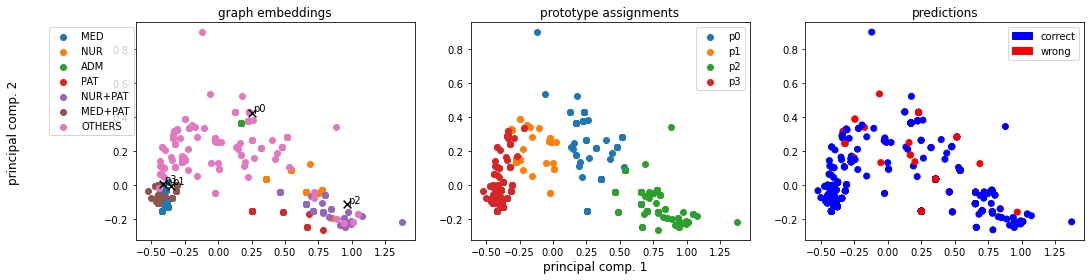

Alpha norms:
tensor([[0.4303, 0.1318, 0.3915, 1.0000],
        [0.1570, 0.2458, 0.9615, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.685389 +- 0.218537
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([194,  51, 120, 344], dtype=int64))
Logic formulas:
For class 0:
0.8956276445698167 (feature000) | (feature002)
For class 1:
0.8956276445698167 (feature003) | (feature001)
Accuracy as classifier:  0.8956

360: Loss: 0.04241, LEN: 0.041743, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03420, V. LEN 0.03
361: Loss: 0.04251, LEN: 0.041864, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03393, V. LEN 0.03
362: Loss: 0.04305, LEN: 0.042492, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03394, V. LEN 0.03
363: Loss: 0.04216, LEN: 0.041700, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03275, V. LEN 0.03
364: Loss: 0.04289, LEN: 0.042406, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03511, V. LEN 0.03
365: Loss: 0.04424, LEN: 0.043698, AccxC: 0.90, AccO

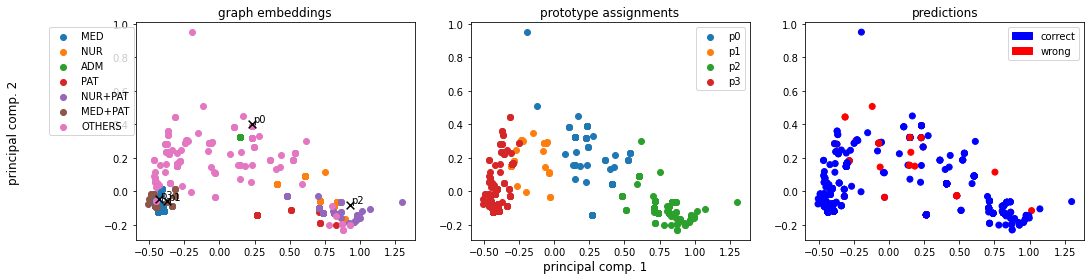

Alpha norms:
tensor([[0.4175, 0.1371, 0.4280, 1.0000],
        [0.1466, 0.2451, 1.0000, 0.9132]], grad_fn=<DivBackward0>)
Concept Purity: 0.676286 +- 0.215724
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([193,  35, 121, 360], dtype=int64))
Logic formulas:
For class 0:
0.8956276445698167 (feature000) | (feature002)
For class 1:
0.8956276445698167 (feature003) | (feature001)
Accuracy as classifier:  0.8956

380: Loss: 0.04429, LEN: 0.043904, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03367, V. LEN 0.03
381: Loss: 0.04404, LEN: 0.043568, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03405, V. LEN 0.03
382: Loss: 0.04319, LEN: 0.042736, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03426, V. LEN 0.03
383: Loss: 0.04164, LEN: 0.041125, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03440, V. LEN 0.03
384: Loss: 0.04628, LEN: 0.045697, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03408, V. LEN 0.03
385: Loss: 0.04291, LEN: 0.042435, AccxC: 0.89, AccO

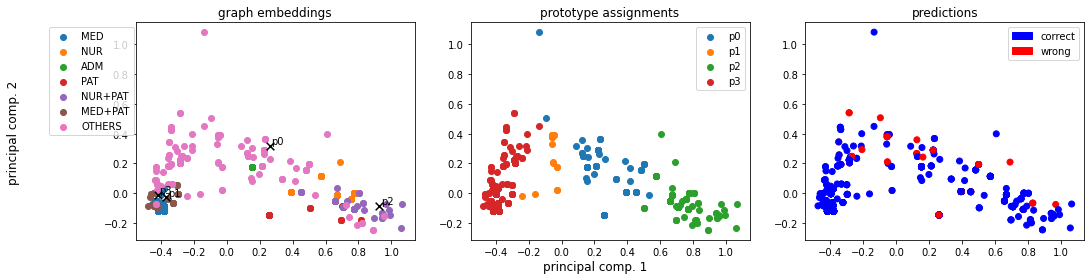

Alpha norms:
tensor([[0.4171, 0.1412, 0.4590, 1.0000],
        [0.1407, 0.2397, 1.0000, 0.8527]], grad_fn=<DivBackward0>)
Concept Purity: 0.658426 +- 0.221359
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([200,  17, 114, 378], dtype=int64))
Logic formulas:
For class 0:
0.8956276445698167 (feature000) | (feature002)
For class 1:
0.8956276445698167 (feature003) | (feature001)
Accuracy as classifier:  0.8956

400: Loss: 0.04227, LEN: 0.041833, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03628, V. LEN 0.04
401: Loss: 0.04449, LEN: 0.044016, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03070, V. LEN 0.03
402: Loss: 0.04132, LEN: 0.040743, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03393, V. LEN 0.03
403: Loss: 0.04267, LEN: 0.042176, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03658, V. LEN 0.04
404: Loss: 0.04358, LEN: 0.043002, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03660, V. LEN 0.04
405: Loss: 0.04397, LEN: 0.043219, AccxC: 0.89, AccO

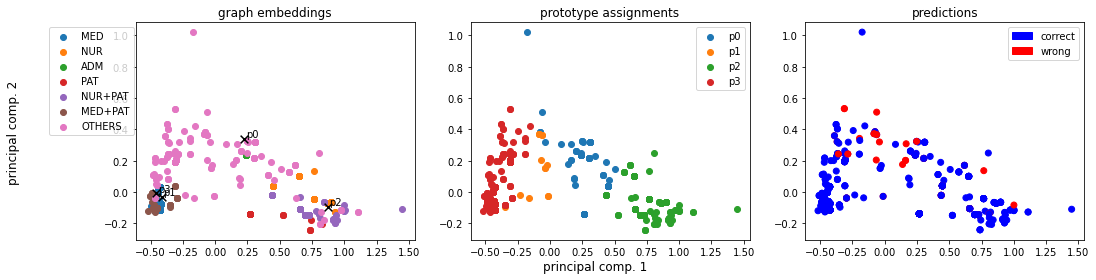

Alpha norms:
tensor([[0.4251, 0.1482, 0.5026, 1.0000],
        [0.1370, 0.2426, 1.0000, 0.7677]], grad_fn=<DivBackward0>)
Concept Purity: 0.644385 +- 0.190199
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([189,  14, 129, 377], dtype=int64))
Logic formulas:
For class 0:
0.8956276445698167 (feature000) | (feature002)
For class 1:
0.8956276445698167 (feature003) | (feature001)
Accuracy as classifier:  0.8956

420: Loss: 0.04277, LEN: 0.042217, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03340, V. LEN 0.03
421: Loss: 0.04051, LEN: 0.040069, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03734, V. LEN 0.04
422: Loss: 0.04299, LEN: 0.042447, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03617, V. LEN 0.04
423: Loss: 0.04433, LEN: 0.043755, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03721, V. LEN 0.04
424: Loss: 0.04286, LEN: 0.042276, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03728, V. LEN 0.04
425: Loss: 0.04370, LEN: 0.043146, AccxC: 0.90, AccO

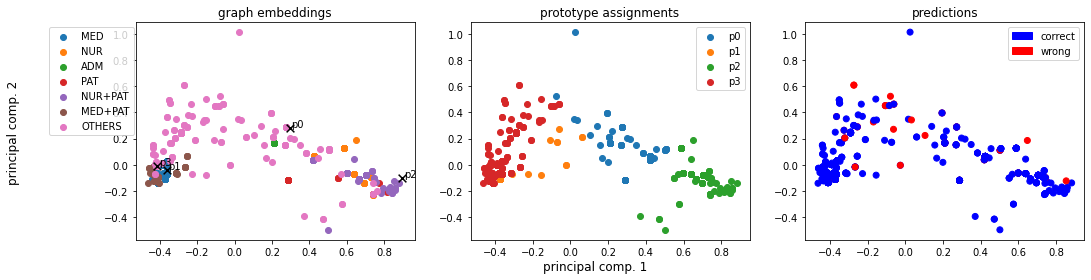

Alpha norms:
tensor([[0.4274, 0.1544, 0.5506, 1.0000],
        [0.1292, 0.2398, 1.0000, 0.6957]], grad_fn=<DivBackward0>)
Concept Purity: 0.599679 +- 0.148938
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([198,  62, 114, 335], dtype=int64))
Logic formulas:
For class 0:
0.8984485190409027 (feature000) | (feature002)
For class 1:
0.8984485190409027 (feature003) | (feature001)
Accuracy as classifier:  0.8984

440: Loss: 0.04405, LEN: 0.043518, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03967, V. LEN 0.04
441: Loss: 0.04477, LEN: 0.044309, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03484, V. LEN 0.03
442: Loss: 0.04167, LEN: 0.041205, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03929, V. LEN 0.04
443: Loss: 0.04271, LEN: 0.042184, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03400, V. LEN 0.03
444: Loss: 0.04272, LEN: 0.042272, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03741, V. LEN 0.04
445: Loss: 0.04393, LEN: 0.043371, AccxC: 0.89, AccO

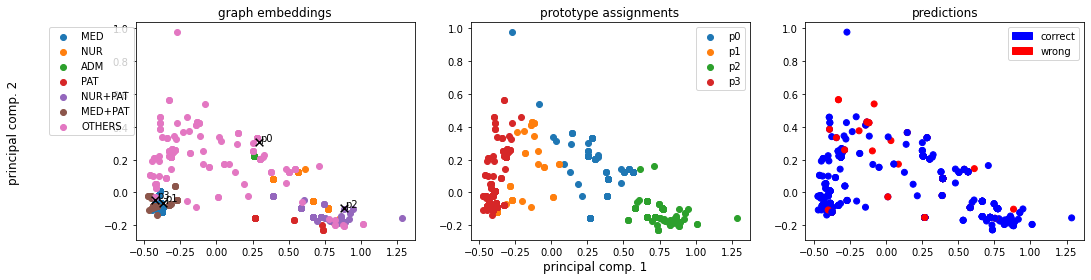

Alpha norms:
tensor([[0.4422, 0.1591, 0.5809, 1.0000],
        [0.1295, 0.2453, 1.0000, 0.6750]], grad_fn=<DivBackward0>)
Concept Purity: 0.578399 +- 0.080744
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([208,  83, 104, 314], dtype=int64))
Logic formulas:
For class 0:
0.8984485190409027 (feature000) | (feature002)
For class 1:
0.8984485190409027 (feature003) | (feature001)
Accuracy as classifier:  0.8984

460: Loss: 0.04322, LEN: 0.042771, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03710, V. LEN 0.04
461: Loss: 0.04166, LEN: 0.041097, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03946, V. LEN 0.04
462: Loss: 0.04191, LEN: 0.041442, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03852, V. LEN 0.04
463: Loss: 0.04201, LEN: 0.041515, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03326, V. LEN 0.03
464: Loss: 0.04261, LEN: 0.042116, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03439, V. LEN 0.03
465: Loss: 0.04269, LEN: 0.042227, AccxC: 0.89, AccO

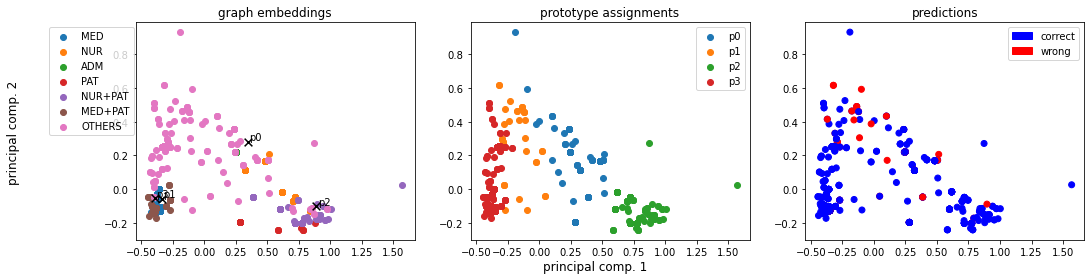

Alpha norms:
tensor([[0.4443, 0.1643, 0.6179, 1.0000],
        [0.1240, 0.2435, 1.0000, 0.6354]], grad_fn=<DivBackward0>)
Concept Purity: 0.662805 +- 0.162694
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([210,  36, 102, 361], dtype=int64))
Logic formulas:
For class 0:
0.8984485190409027 (feature000) | (feature002)
For class 1:
0.8984485190409027 (feature003) | (feature001)
Accuracy as classifier:  0.8984

480: Loss: 0.04195, LEN: 0.041522, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03673, V. LEN 0.04
481: Loss: 0.04244, LEN: 0.042068, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03548, V. LEN 0.03
482: Loss: 0.04032, LEN: 0.039973, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03667, V. LEN 0.04
483: Loss: 0.04104, LEN: 0.040472, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03633, V. LEN 0.04
484: Loss: 0.04142, LEN: 0.040865, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03289, V. LEN 0.03
485: Loss: 0.04344, LEN: 0.042886, AccxC: 0.89, AccO

In [24]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)

torch.manual_seed(42)
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 4,
    "dim_prototypes": 10,
    "num_le_features": 5,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": True,
    "num_epochs": 500
}

len_model    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"]).to(device)
expl4         = models.GlobalExplainer(len_model, 
                               le_model, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=priori_etn_classes_names,
                               dataset_name="ETN").to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
suffix = "no attn" if hyper["remove_attention"] else ""
expl4.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb=f"MUTAG {hyper['num_prototypes']}prots {prefix} {suffix}")

(array([0., 1., 2., 3., 4., 5., 6.], dtype=float32), array([19,  7,  4,  7, 11,  2, 16], dtype=int64))
[0.80661744 0.13246137]


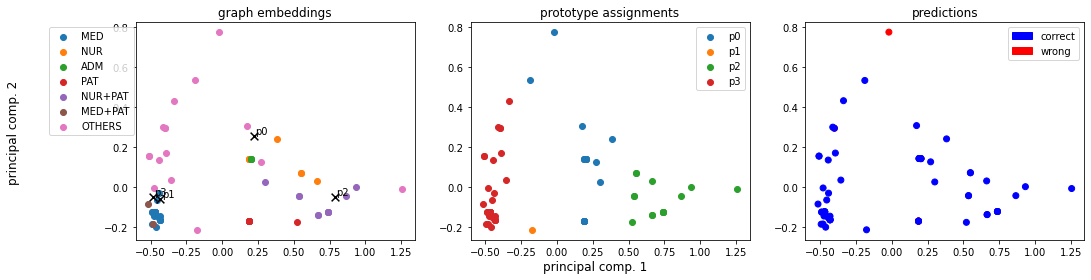

Alpha norms:
tensor([[0.4323, 0.1604, 0.6414, 1.0000],
        [0.1185, 0.2268, 1.0000, 0.6227]], grad_fn=<DivBackward0>)
Concept Purity: 0.648840 +- 0.242820
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([19,  1, 15, 31], dtype=int64))
Logic formulas:
For class 0:
0.9242424242424242 (feature002) | (feature000)
For class 1:
0.9242424242424242 (feature003) | (feature001)
Accuracy as classifier:  0.9242



In [26]:
expl4.inspect_embedding(val_group_loader)

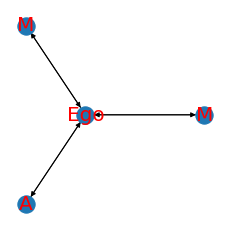

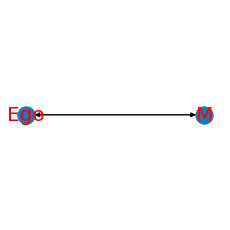

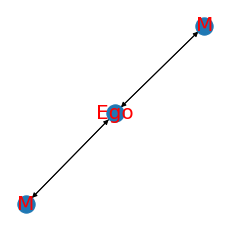

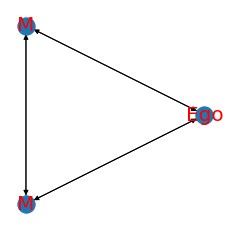

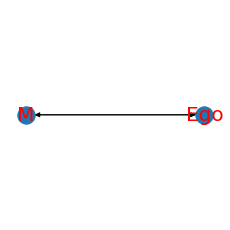

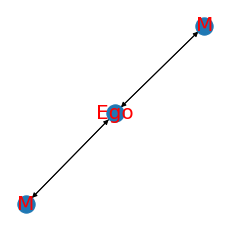

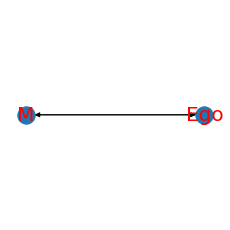

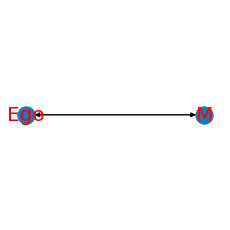

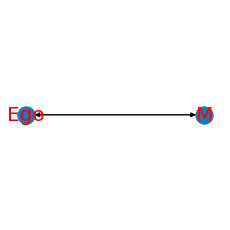

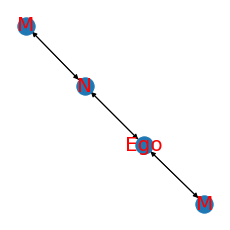

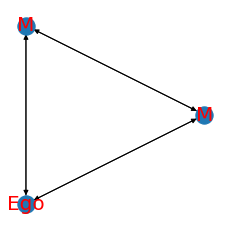

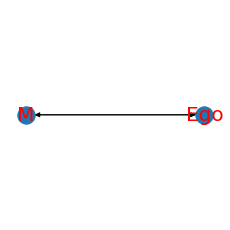

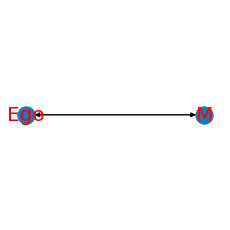

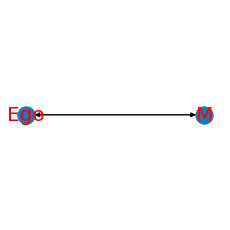

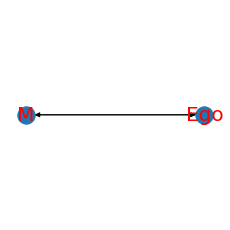

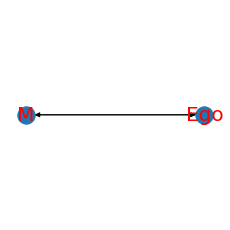

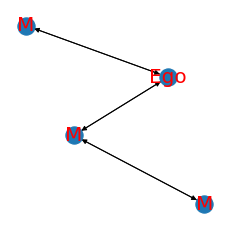

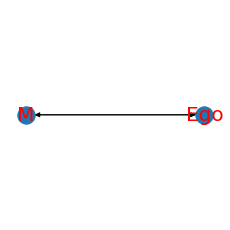

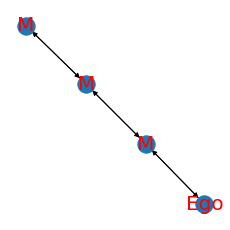

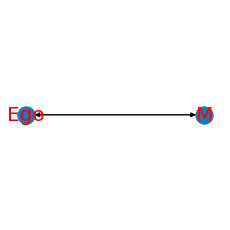

In [24]:
x_train , emb , concepts_assignement , y_train_1h , le_classes , le_idxs , belonging = expl4.get_concept_vector(train_group_loader, 
                                                                                                               return_raw=True)        

prototype_assignements = utils.prototype_assignement("sim", emb, expl4.prototype_vectors, temp=1)

idxs = le_idxs[prototype_assignements.argmax(-1) == 3]
argsort = torch.argsort(prototype_assignements[prototype_assignements.argmax(-1) == 1, 3], descending=True)
#idxs = le_idxs[concepts_assignement.argmax(-1) == 0]
for idx in idxs[argsort][:20]: 
    plt.figure(figsize=(3,3))
    plot_etn(dataset_train[int(idx)])
    plt.show()

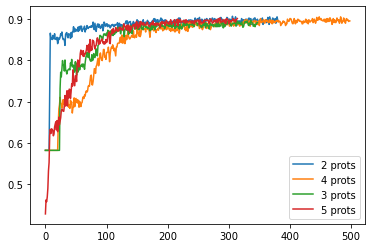

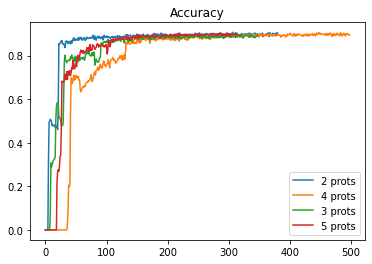

In [14]:
plt.plot([i["acc_per_class"] for i in expl.train_metrics], label="2 prots")
plt.plot([i["acc_per_class"] for i in expl4.train_metrics], label="4 prots")
plt.plot([i["acc_per_class"] for i in expl3.train_metrics], label="3 prots")
plt.plot([i["acc_per_class"] for i in expl5.train_metrics], label="5 prots")
plt.legend()
plt.show()

plt.plot([i["acc_overall"] for i in expl.train_metrics], label="2 prots")
plt.plot([i["acc_overall"] for i in expl4.train_metrics], label="4 prots")
plt.plot([i["acc_overall"] for i in expl3.train_metrics], label="3 prots")
plt.plot([i["acc_overall"] for i in expl5.train_metrics], label="5 prots")
plt.legend()
plt.title("Accuracy")
plt.show()